In [1]:
import pandas as pd
import os
from tqdm import tqdm
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

/cluster/apps/nss/gcc-6.3.0/python/3.8.5/x86_64/lib64/python3.8/site-packages/pyproj/__init__.py:78: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_LIB or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


In [2]:
pd.options.display.max_columns = 999


In [3]:
import plotting_utils
import utils

In [12]:

def read_fixed_demand_output(output_directory, read_zones=True, last_iter=-1):
    drt_legs = []
    global_stats = []
    drt_trips_stats = []
    drt_simulated_predictions = []
    
    iter_0_path = os.path.join(output_directory,'ITERS','it.0')
    binned = '0.drt_zonalAndTimeBinWaitingTime.csv' in os.listdir(iter_0_path)
    iter_0_path += '/0.'
    
    
    global_stats = global_stats.append(pd.read_csv(iter_0_path + 'drt_globalStats.csv', sep=';'))
    drt_legs = pd.read_csv(iter_0_path + 'drt_legs_drt.csv', sep=';')
    drt_trips_stats = pd.read_csv(iter_0_path + 'drt_drtTripsStats.csv', sep=';')
    drt_simulated_predictions = pd.read_csv(iter_0_path + 'drt_simulatedTrips.csv', sep=';')

        
    d = {'drt_legs': drt_legs,
         'global_stats': global_stats,
         'drt_trips_stats': drt_trips_stats,
         'drt_simulated_predictions': drt_simulated_predictions
        }
    
    if binned:
        binned_wait_time = pd.read_csv(iter_0_path + 'drt_zonalAndTimeBinWaitingTime.csv', sep=';')
        binned_delay_factor = pd.read_csv(iter_0_path + 'drt_distanceAndTimeBinDelayFactor.csv', sep=';')
        d['binned_wait_time'] = binned_wait_time
        d['binned_delay_factor'] = binned_delay_factor
    
    if read_zones and 'drt_link2FixedZones.csv' in os.listdir(output_directory):
        link2zones_csv = pd.read_csv(os.path.join(output_directory,'drt_link2FixedZones.csv'), sep=';')
        link2zones_csv = link2zones_csv.set_index('link_id')
        link2zones = {}
        for link_id, zone in link2zones_csv.iterrows():
            link2zones[link_id] = zone.zone
        fixed_zones = gpd.read_file(os.path.join(output_directory,'drt_FixedZones.shp'))
        d['link2zones'] = link2zones
        d['fixedZones'] = fixed_zones
    
    #Read stopwatch.txt
    stopwatch = pd.read_csv(os.path.join(output_directory,'stopwatch.txt'), sep='\t')
    d['stopwatch'] = stopwatch
    
    return d

In [5]:
scratch_folder = '/cluster/scratch/mfrancesc/IVT/SA_scenario'
work_folder = '/cluster/work/ivt_vpl/mfrancesc/SA_scenario'

In [6]:
configs = ['global_average',
 'zonal_hex_500',
 'zonal_hex_1000',
 'zonal_square_500',
 'zonal_square_1000',
 'dynamic_CN_k25_expDecay',
 'dynamic_PN_km25_expDecay',
 'dynamic_FD_expDecay_500'
 ]

In [10]:
nr_trips_per_vehicle = [
    10, 20, 30, 40, 50, 75
]

In [13]:
outputs_varyVehicles = {}
fd_value = 200000
for n in nr_trips_per_vehicle:
    outputs_varyVehicles[n] = {}
    for c in tqdm(configs):
        path = os.path.join(work_folder,
                            f'fixedDemand/fixedDemand_{fd_value}/useClean/varyNrVehicles/tripsPerVehicle_{n}.0/{c}')
        outputs_varyVehicles[n][c] = read_fixed_demand_output(path, read_zones=False)

100%|██████████| 8/8 [00:16<00:00,  2.09s/it]


In [18]:
def compute_error_stats(simulated):
    true_labels = simulated['waitTime_real'] / 60
    predicted_labels = simulated['waitTime_predicted'] / 60
    errors = true_labels - predicted_labels
    
    current_description = pd.Series(errors).describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])
    current_description = current_description.add_prefix('error_')
    abs_error_desc = pd.Series(np.abs(errors)).describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])
    abs_error_desc = abs_error_desc.add_prefix('abs_error_')
    current_description = current_description.append(abs_error_desc)
    
    # Add mse, rmse, mae
    current_description['MSE'] = np.mean(errors**2)
    current_description['RMSE'] = np.sqrt(current_description['MSE'])
    current_description['MAE'] = np.mean(np.abs(errors))
    # Add percentage of errors below 0
    current_description['% errors < 0 (overestimation)'] = np.sum(errors < 0)/len(errors) * 100
    
    # Add percentage of trips with less than x% error
    current_description['% relative errors < 0.2'] = np.sum(abs(errors) <= 0.2*true_labels)/len(errors) * 100
    current_description['% relative errors < 0.1'] = np.sum(abs(errors) <= 0.1*true_labels)/len(errors) * 100
    
    current_description['Avg std'] = simulated['waitTime_std'].mean() / 60
    current_description['Avg weighted std'] = simulated['waitTime_weightedStd'].mean() / 60
    current_description['% in 1 std'] = ((simulated['waitTime_real'] >= simulated['waitTime_predicted'] - simulated['waitTime_std']) & (simulated['waitTime_real'] <= simulated['waitTime_predicted'] + simulated['waitTime_std'])).sum() / simulated.shape[0] * 100
    current_description['% in 1 wieghted std'] = ((simulated['waitTime_real'] >= simulated['waitTime_predicted'] - simulated['waitTime_weightedStd']) & (simulated['waitTime_real'] <= simulated['waitTime_predicted'] + simulated['waitTime_weightedStd'])).sum() / simulated.shape[0] * 100

    current_description['Avg of used trips to predict'] = simulated['waitTime_nTrips'].mean()
    current_description['Median of used trips to predict'] = simulated['waitTime_nTrips'].median()
    try:
        current_description['% of trips predicted using 1 trip'] = simulated['waitTime_nTrips'].value_counts(normalize=True).loc[1.0]*100
    except:
        current_description['% of trips predicted using 1 trip'] = 0
        
    current_description = pd.DataFrame(current_description).T
    
    # Reorder columns
    current_description = current_description[[
        'error_mean', 'error_std', 'error_50%',
        'abs_error_std', 'abs_error_50%', 
        'MSE', 'RMSE', 'MAE', 
        '% relative errors < 0.2', '% relative errors < 0.1',
        '% errors < 0 (overestimation)',
        '% in 1 std', '% in 1 wieghted std', 'Avg of used trips to predict', 'Median of used trips to predict',
        '% of trips predicted using 1 trip',
        'Avg std', 'Avg weighted std',
        'abs_error_count', 'abs_error_min', 'abs_error_1%', 'abs_error_5%', 'abs_error_25%', 'abs_error_75%', 
        'abs_error_95%', 'abs_error_99%', 'abs_error_max',
        'error_count', 'error_min', 'error_1%', 'error_5%', 'error_25%', 'error_75%', 'error_95%',
        'error_99%', 'error_max'
    ]]
    return current_description


In [21]:
def compute_stats_table_nr_vehicles(outputs_dict):
    description = pd.DataFrame()
    nr_trips_per_vehicle = list(outputs_dict.keys())
    configs = list(outputs_dict[nr_trips_per_vehicle[0]].keys())
    
    for n in nr_trips_per_vehicle:
        for c in configs:
            o = outputs_dict[n][c]
            simulated = o['drt_simulated_predictions']
            #merged = combine_simulated_predictions_and_stats(o['drt_simulated_predictions'], o['drt_trips_stats'])

            current_description = compute_error_stats(simulated)
            
            current_description['Nr trips per vehicle'] = n
            current_description['Method'] = c
            
            description = pd.concat([description, current_description], axis=0)
    description = description.set_index(['Nr trips per vehicle', 'Method'])
    return description

In [22]:
compute_stats_table_nr_vehicles(outputs_varyVehicles)

error_mean  error_std  \
Nr trips per vehicle Method                                              
10                   global_average            8.908980e-16   3.683423   
                     zonal_hex_500            -7.600286e-03   3.285510   
                     zonal_hex_1000           -4.726562e-04   3.273001   
                     zonal_square_500         -2.358269e-02   3.235582   
                     zonal_square_1000        -4.461736e-03   3.221365   
                     dynamic_CN_k25_expDecay  -1.588354e-02   3.148185   
                     dynamic_PN_km25_expDecay -7.387078e-03   3.147457   
                     dynamic_FD_expDecay_500  -1.410991e-02   3.241685   
20                   global_average           -1.853133e-15   4.775169   
                     zonal_hex_500            -3.278847e-03   3.722580   
                     zonal_hex_1000           -2.829975e-03   3.687038   
                     zonal_square_500          6.577199e-03   3.724939   
                     zonal_square_1000        -3.012902e-03   3.663881   
                     dynamic_CN_k25_expDecay  -1.766885e-03   3.542371   
                     dynamic_PN_km25_expDecay -9.468711e-03   3.547181   
                     dynamic_FD_expDecay_500  -3.569101e-03   3.665300   
30                   global_average            1.543395e-15   8.872092   
                     zonal_hex_500            -3.017040e-02   5.869594   
                     zonal_hex_1000           -9.985284e-03   5.821330   
                     zonal_square_500         -5.456290e-02   5.902793   
                     zonal_square_1000        -2.228684e-02   5.776041   
                     dynamic_CN_k25_expDecay   4.801742e-02   5.613448   
                     dynamic_PN_km25_expDecay  5.426036e-02   5.613207   
                     dynamic_FD_expDecay_500   4.922466e-04   5.741031   
40                   global_average            2.202756e-16  10.265938   
                     zonal_hex_500            -4.728989e-02   6.988603   
                     zonal_hex_1000           -1.504709e-02   6.924318   
                     zonal_square_500         -8.265953e-02   7.052483   
                     zonal_square_1000        -3.480543e-02   6.868238   
                     dynamic_CN_k25_expDecay   7.722177e-02   6.670945   
                     dynamic_PN_km25_expDecay  8.161713e-02   6.668864   
                     dynamic_FD_expDecay_500  -5.194491e-03   6.850331   
50                   global_average            9.484297e-17  11.462796   
                     zonal_hex_500            -6.267032e-02   8.083777   
                     zonal_hex_1000           -2.050700e-02   8.006160   
                     zonal_square_500         -1.095028e-01   8.209073   
                     zonal_square_1000        -4.491561e-02   7.961409   
                     dynamic_CN_k25_expDecay   1.160958e-01   7.712412   
                     dynamic_PN_km25_expDecay  8.064609e-02   7.714259   
                     dynamic_FD_expDecay_500  -1.328456e-02   7.922942   
75                   global_average           -6.782318e-16  17.206528   
                     zonal_hex_500            -1.003046e-01  11.654497   
                     zonal_hex_1000           -3.273887e-02  11.518157   
                     zonal_square_500         -1.903963e-01  11.918343   
                     zonal_square_1000        -7.564087e-02  11.479360   
                     dynamic_CN_k25_expDecay   1.092641e-01  11.116657   
                     dynamic_PN_km25_expDecay  1.199235e-01  11.116128   
                     dynamic_FD_expDecay_500  -3.413861e-02  11.411689   

                                               error_50%  abs_error_std  \
Nr trips per vehicle Method                                               
10                   global_average            -1.261167       2.749176   
                     zonal_hex_500             -0.583333       2.613711   
                     zonal_hex_1000            -

In [23]:
def compute_error_stats_by_time(simulated):
    hours_pairs = [(7, 9), (9, 11), (11, 15), (15, 19), (19, 7)]
    description = pd.DataFrame()
    for start_time_h, end_time_h in hours_pairs:
        if start_time_h <= end_time_h:
            selected_simulated = simulated[(simulated['startTime'] >= start_time_h*3600) & (simulated['startTime'] < end_time_h*3600)]
        else:
            # If end_time_h is smaller than start_time_h, then we have to go through midnight
            selected_simulated = simulated[(simulated['startTime'] >= start_time_h*3600) | (simulated['startTime'] < end_time_h*3600)]
        current_description = compute_error_stats(selected_simulated)
        current_description['Hours'] = f'{start_time_h}h - {end_time_h}h'
        description = pd.concat([description, current_description], axis=0)
    description = description.set_index(['Hours'])
    return description
        

In [24]:
compute_error_stats_by_time(outputs_varyVehicles[10]['dynamic_CN_k25_expDecay']['drt_simulated_predictions'])

error_mean  error_std  error_50%  abs_error_std  abs_error_50%  \
Hours                                                                       
7h - 9h     -0.025285   2.948149  -0.580667       2.228733       1.317458   
9h - 11h    -0.007366   2.805004  -0.596458       2.142804       1.234094   
11h - 15h    0.004811   2.848391  -0.653337       2.220467       1.242322   
15h - 19h   -0.000333   3.576078  -0.694444       2.890128       1.491891   
19h - 7h    -0.059931   3.072684  -0.659722       2.377943       1.313240   

                 MSE      RMSE       MAE  % relative errors < 0.2  \
Hours                                                               
7h - 9h     8.691898  2.948202  1.929983                19.770030   
9h - 11h    7.867682  2.804939  1.810060                17.091454   
11h - 15h   8.113183  2.848365  1.784044                15.900065   
15h - 19h  12.788128  3.576049  2.106045                16.057953   
19h - 7h    9.444751  3.073231  1.946863                18.331779   

           % relative errors < 0.1  % errors < 0 (overestimation)  % in 1 std  \
Hours                                                                           
7h - 9h                  10.192878                      61.754451   77.937685   
9h - 11h                  8.069180                      63.514671   79.326408   
11h - 15h                 7.955286                      64.205417   80.876636   
15h - 19h                 7.930156                      63.748326   78.809905   
19h - 7h                  8.847928                      64.789978   78.768319   

           % in 1 wieghted std  Avg of used trips to predict  \
Hours                                                          
7h - 9h              77.974777                     24.244065   
9h - 11h             79.240737                     24.117156   
11h - 15h            80.891345                     24.114412   
15h - 19h            78.770703                     24.124122   
19h - 7h             78.734849                     24.158861   

           Median of used trips to predict  % of trips predicted using 1 trip  \
Hours                                                                           
7h - 9h                               24.0                                0.0   
9h - 11h                              24.0                                0.0   
11h - 15h                             24.0                                0.0   
15h - 19h                             24.0                                0.0   
19h - 7h                              24.0                                0.0   

            Avg std  Avg weighted std  abs_error_count  abs_error_min  \
Hours                                                                   
7h - 9h    2.502830          2.501063          26960.0       0.000000   
9h - 11h   2.386344          2.377523          18676.0       0.000000   
11h - 15h  2.361449          2.355083          47591.0       0.000000   
15h - 19h  2.743359          2.737102          61222.0       0.000003   
19h - 7h   2.577419          2.549388          41829.0       0.000022   

           abs_error_1%  abs_error_5%  abs_error_25%  abs_error_75%  \
Hours                                                                 
7h - 9h        0.028211      0.145845       0.675950       2.308786   
9h - 11h       0.033337      0.155712       0.655557       2.078790   
11h - 15h      0.030881      0.148924       0.679214       2.058285   
15h - 19h      0.034700      0.167299       0.769591       2.522728   
19h - 7h       0.029670      0.146501       0.701129       2.270204   

           abs_error_95%  abs_error_99%  abs_error_max  error_count  \
Hours                                                                 
7h - 9h         6.124232       9.786000      65.875901      26960.0   
9h - 11h        5.823262       9.745817      65.941181      18676.0   
11h - 15h       5.506205      10.141017     128.813587      47591.0   
15h - 19h       6.189322      11.2098

In [25]:
compute_error_stats_by_time(outputs_varyVehicles[20]['dynamic_CN_k25_expDecay']['drt_simulated_predictions'])

error_mean  error_std  error_50%  abs_error_std  abs_error_50%  \
Hours                                                                       
7h - 9h      0.001684   3.280408  -0.465278       2.379747       1.550000   
9h - 11h     0.025566   3.279192  -0.477070       2.457850       1.464721   
11h - 15h    0.024719   3.076748  -0.546953       2.333813       1.402028   
15h - 19h    0.013550   3.909836  -0.473264       2.977357       1.804730   
19h - 7h    -0.068831   3.741489  -0.436102       2.821505       1.629861   

                 MSE      RMSE       MAE  % relative errors < 0.2  \
Hours                                                               
7h - 9h    10.760682  3.280348  2.257808                25.072356   
9h - 11h   10.753180  3.279204  2.170824                24.668023   
11h - 15h   9.466790  3.076815  2.005049                20.943816   
15h - 19h  15.286754  3.909828  2.534215                24.721818   
19h - 7h   14.003139  3.742077  2.458138                29.370646   

           % relative errors < 0.1  % errors < 0 (overestimation)  % in 1 std  \
Hours                                                                           
7h - 9h                  12.615955                      58.452690   73.465677   
9h - 11h                 12.063611                      58.818805   74.694795   
11h - 15h                10.513930                      60.988780   76.652519   
15h - 19h                12.292283                      57.543177   73.804350   
19h - 7h                 15.040816                      57.901037   74.564910   

           % in 1 wieghted std  Avg of used trips to predict  \
Hours                                                          
7h - 9h              73.476809                     24.244007   
9h - 11h             74.657314                     24.116995   
11h - 15h            76.534857                     24.114447   
15h - 19h            73.716116                     24.124165   
19h - 7h             74.315946                     24.159146   

           Median of used trips to predict  % of trips predicted using 1 trip  \
Hours                                                                           
7h - 9h                               24.0                                0.0   
9h - 11h                              24.0                                0.0   
11h - 15h                             24.0                                0.0   
15h - 19h                             24.0                                0.0   
19h - 7h                              24.0                                0.0   

            Avg std  Avg weighted std  abs_error_count  abs_error_min  \
Hours                                                                   
7h - 9h    2.855255          2.849830          26950.0       0.000000   
9h - 11h   2.782868          2.773000          18676.0       0.000073   
11h - 15h  2.619050          2.609334          47594.0       0.000000   
15h - 19h  3.234326          3.227249          61201.0       0.000000   
19h - 7h   3.226745          3.191999          41773.0       0.000000   

           abs_error_1%  abs_error_5%  abs_error_25%  abs_error_75%  \
Hours                                                                 
7h - 9h        0.032139      0.151852       0.742014       2.896648   
9h - 11h       0.032580      0.145438       0.715278       2.681542   
11h - 15h      0.029619      0.143109       0.700769       2.452088   
15h - 19h      0.035130      0.173253       0.851518       3.264778   
19h - 7h       0.027799      0.150000       0.778275       3.148649   

           abs_error_95%  abs_error_99%  abs_error_max  error_count  \
Hours                                                                 
7h - 9h         7.082133      10.543582      44.607046      26950.0   
9h - 11h        6.840216      10.844773      81.273080      18676.0   
11h - 15h       6.114510      10.563919     128.781252      47594.0   
15h - 19h       7.314583      12.0982

In [26]:
compute_error_stats_by_time(outputs_varyVehicles[30]['dynamic_CN_k25_expDecay']['drt_simulated_predictions'])

error_mean  error_std  error_50%  abs_error_std  abs_error_50%  \
Hours                                                                       
7h - 9h     -0.004279   3.862473  -0.373915       2.794189       1.805895   
9h - 11h     0.075764   3.635501  -0.345004       2.684088       1.629861   
11h - 15h    0.017085   3.408940  -0.444243       2.576704       1.544085   
15h - 19h    0.117009   8.280647   0.311090       5.824069       4.157452   
19h - 7h     0.003724   4.342185  -0.423539       3.338229       1.761861   

                 MSE      RMSE       MAE  % relative errors < 0.2  \
Hours                                                               
7h - 9h    14.918159  3.862403  2.666638                29.863044   
9h - 11h   13.221900  3.636193  2.453152                28.494221   
11h - 15h  11.620923  3.408947  2.231963                25.498477   
15h - 19h  68.581687  8.281406  5.887484                31.255318   
19h - 7h   18.854132  4.342134  2.776802                27.685654   

           % relative errors < 0.1  % errors < 0 (overestimation)  % in 1 std  \
Hours                                                                           
7h - 9h                  15.391753                      56.044242   71.892514   
9h - 11h                 13.864512                      56.052012   72.934503   
11h - 15h                12.595861                      57.764471   73.740939   
15h - 19h                14.310492                      47.805812   68.491066   
19h - 7h                 13.633757                      56.582720   73.628500   

           % in 1 wieghted std  Avg of used trips to predict  \
Hours                                                          
7h - 9h              71.710648                     24.243885   
9h - 11h             72.800728                     24.117295   
11h - 15h            73.635886                     24.114445   
15h - 19h            68.383075                     24.123928   
19h - 7h             73.423014                     24.159084   

           Median of used trips to predict  % of trips predicted using 1 trip  \
Hours                                                                           
7h - 9h                               24.0                                0.0   
9h - 11h                              24.0                                0.0   
11h - 15h                             24.0                                0.0   
15h - 19h                             24.0                                0.0   
19h - 7h                              24.0                                0.0   

            Avg std  Avg weighted std  abs_error_count  abs_error_min  \
Hours                                                                   
7h - 9h    3.351063          3.343998          26943.0       0.000000   
9h - 11h   3.105237          3.096959          18688.0       0.000118   
11h - 15h  2.870361          2.862523          47595.0       0.000038   
15h - 19h  7.157762          7.146826          61116.0       0.000000   
19h - 7h   3.586483          3.552188          41852.0       0.000000   

           abs_error_1%  abs_error_5%  abs_error_25%  abs_error_75%  \
Hours                                                                 
7h - 9h        0.036136      0.177701       0.827377       3.585671   
9h - 11h       0.034722      0.166168       0.772594       3.179230   
11h - 15h      0.028000      0.159974       0.739982       2.831310   
15h - 19h      0.072667      0.356000       1.779924       8.323691   
19h - 7h       0.033333      0.176373       0.859450       3.430021   

           abs_error_95%  abs_error_99%  abs_error_max  error_count  \
Hours                                                                 
7h - 9h         8.082200      12.242893      80.916667      26943.0   
9h - 11h        7.449936      12.211753      50.924334      18688.0   
11h - 15h       6.635812      11.002747     125.985209      47595.0   
15h - 19h      17.075645      24.6177

In [27]:
compute_error_stats_by_time(outputs_varyVehicles[40]['dynamic_CN_k25_expDecay']['drt_simulated_predictions'])

error_mean  error_std  error_50%  abs_error_std  abs_error_50%  \
Hours                                                                       
7h - 9h      0.013991   4.570176  -0.201428       3.277699       2.131993   
9h - 11h     0.050984   3.971003  -0.264705       2.921543       1.796949   
11h - 15h    0.052757   4.506733  -0.178776       3.316282       2.164617   
15h - 19h    0.184096  10.026779   0.995833       6.668279       5.887282   
19h - 7h     0.001303   4.259893  -0.411627       3.264452       1.784028   

                  MSE       RMSE       MAE  % relative errors < 0.2  \
Hours                                                                 
7h - 9h     20.885927   4.570112  3.184811                35.701823   
9h - 11h    15.770622   3.971224  2.689920                31.773201   
11h - 15h   20.313000   4.506995  3.052131                32.404372   
15h - 19h  100.568544  10.028387  7.490215                34.417677   
19h - 7h    18.146259   4.259843  2.736762                28.684431   

           % relative errors < 0.1  % errors < 0 (overestimation)  % in 1 std  \
Hours                                                                           
7h - 9h                  18.580391                      52.637636   71.128930   
9h - 11h                 15.581706                      53.960952   72.265312   
11h - 15h                16.378731                      52.166877   70.964691   
15h - 19h                15.888982                      44.809708   67.504048   
19h - 7h                 14.448560                      56.823993   73.148524   

           % in 1 wieghted std  Avg of used trips to predict  \
Hours                                                          
7h - 9h              70.961874                     24.244162   
9h - 11h             72.195774                     24.117090   
11h - 15h            70.891131                     24.114397   
15h - 19h            67.471338                     24.123955   
19h - 7h             72.775720                     24.158992   

           Median of used trips to predict  % of trips predicted using 1 trip  \
Hours                                                                           
7h - 9h                               24.0                                0.0   
9h - 11h                              24.0                                0.0   
11h - 15h                             24.0                                0.0   
15h - 19h                             24.0                                0.0   
19h - 7h                              24.0                                0.0   

            Avg std  Avg weighted std  abs_error_count  abs_error_min  \
Hours                                                                   
7h - 9h    4.007345          4.001813          26937.0       0.000480   
9h - 11h   3.412423          3.401656          18695.0       0.000327   
11h - 15h  3.841455          3.833008          47580.0       0.000089   
15h - 19h  9.097893          9.084862          61143.0       0.000000   
19h - 7h   3.548141          3.515505          41845.0       0.000000   

           abs_error_1%  abs_error_5%  abs_error_25%  abs_error_75%  \
Hours                                                                 
7h - 9h        0.039031      0.184345       0.955750       4.474993   
9h - 11h       0.039303      0.165276       0.860356       3.462224   
11h - 15h      0.040692      0.207079       1.003145       4.161759   
15h - 19h      0.098000      0.482654       2.647710      10.463838   
19h - 7h       0.033963      0.169028       0.827808       3.449306   

           abs_error_95%  abs_error_99%  abs_error_max  error_count  \
Hours                                                                 
7h - 9h         9.439753      14.078830      79.086111      26937.0   
9h - 11h        8.267640      13.111858      77.121978      18695.0   
11h - 15h       8.831418      12.921402     186.101071      47580.0   
15h - 19h      20.20338

In [28]:
compute_error_stats_by_time(outputs_varyVehicles[50]['dynamic_CN_k25_expDecay']['drt_simulated_predictions'])

error_mean  error_std  error_50%  abs_error_std  abs_error_50%  \
Hours                                                                       
7h - 9h      0.106939   5.362755   0.036111       3.842031       2.581245   
9h - 11h     0.063543   4.281152  -0.101772       3.053122       2.057893   
11h - 15h    0.081015   7.196505   0.741333       4.988006       3.805780   
15h - 19h    0.228865  10.889110   1.470175       7.025490       6.716353   
19h - 7h     0.020424   4.465999  -0.379096       3.418501       1.846435   

                  MSE       RMSE       MAE  % relative errors < 0.2  \
Hours                                                                 
7h - 9h     28.769506   5.363721  3.742840                40.508116   
9h - 11h    18.331316   4.281509  3.001710                36.430710   
11h - 15h   51.795161   7.196886  5.188013                39.345021   
15h - 19h  118.623162  10.891426  8.322647                34.159095   
19h - 7h    19.945090   4.465993  2.873886                29.252968   

           % relative errors < 0.1  % errors < 0 (overestimation)  % in 1 std  \
Hours                                                                           
7h - 9h                  20.729488                      49.611856   71.139918   
9h - 11h                 17.809025                      51.352652   70.412746   
11h - 15h                18.519142                      44.318397   70.418622   
15h - 19h                15.448722                      43.785542   67.341003   
19h - 7h                 15.036193                      55.923457   72.443202   

           % in 1 wieghted std  Avg of used trips to predict  \
Hours                                                          
7h - 9h              71.113917                     24.244066   
9h - 11h             70.332549                     24.117301   
11h - 15h            70.370214                     24.114411   
15h - 19h            67.274005                     24.123881   
19h - 7h             72.158914                     24.159082   

           Median of used trips to predict  % of trips predicted using 1 trip  \
Hours                                                                           
7h - 9h                               24.0                                0.0   
9h - 11h                              24.0                                0.0   
11h - 15h                             24.0                                0.0   
15h - 19h                             24.0                                0.0   
19h - 7h                              24.0                                0.0   

            Avg std  Avg weighted std  abs_error_count  abs_error_min  \
Hours                                                                   
7h - 9h    4.710910          4.704837          26923.0       0.000007   
9h - 11h   3.792070          3.783706          18704.0       0.000000   
11h - 15h  6.432698          6.422740          47513.0       0.000195   
15h - 19h  9.971844          9.959955          61196.0       0.000694   
19h - 7h   3.678665          3.649067          41859.0       0.000000   

           abs_error_1%  abs_error_5%  abs_error_25%  abs_error_75%  \
Hours                                                                 
7h - 9h        0.048158      0.217333       1.099194       5.218702   
9h - 11h       0.038097      0.202763       0.935807       4.062450   
11h - 15h      0.063971      0.331817       1.651333       7.159251   
15h - 19h      0.121333      0.600060       3.158237      11.620340   
19h - 7h       0.035413      0.170139       0.859195       3.621613   

           abs_error_95%  abs_error_99%  abs_error_max  error_count  \
Hours                                                                 
7h - 9h        10.958533      16.362300      94.286000      26923.0   
9h - 11h        8.984607      14.163479      48.422353      18704.0   
11h - 15h      14.872744      22.818294     134.516313      47513.0   
15h - 19h      21.74746

In [29]:
compute_error_stats_by_time(outputs_varyVehicles[75]['dynamic_CN_k25_expDecay']['drt_simulated_predictions'])

error_mean  error_std  error_50%  abs_error_std  abs_error_50%  \
Hours                                                                       
7h - 9h     -0.026431   7.576984   0.840246       5.140381       4.190704   
9h - 11h     0.091786   4.728631   0.058017       3.322560       2.397744   
11h - 15h    0.104947   9.346278   1.482896       6.100240       5.610741   
15h - 19h    0.203314  15.719385   2.766266      10.152572       9.431687   
19h - 7h     0.072584   8.558757  -0.276632       6.733250       2.788029   

                  MSE       RMSE        MAE  % relative errors < 0.2  \
Hours                                                                  
7h - 9h     57.409256   7.576890   5.566572                48.184254   
9h - 11h    22.367180   4.729395   3.365764                38.413984   
11h - 15h   87.362098   9.346769   7.081663                39.871261   
15h - 19h  247.136357  15.720571  12.002639                36.619418   
19h - 7h    73.255848   8.558963   5.283963                30.906848   

           % relative errors < 0.1  % errors < 0 (overestimation)  % in 1 std  \
Hours                                                                           
7h - 9h                  24.040036                      44.024408   70.252270   
9h - 11h                 19.148369                      49.408442   69.707951   
11h - 15h                17.880432                      41.955909   69.771551   
15h - 19h                16.395381                      41.865545   68.856659   
19h - 7h                 15.211408                      53.067907   70.851326   

           % in 1 wieghted std  Avg of used trips to predict  \
Hours                                                          
7h - 9h              70.218783                     24.244047   
9h - 11h             69.580047                     24.117779   
11h - 15h            69.710547                     24.114498   
15h - 19h            68.851732                     24.123565   
19h - 7h             70.526266                     24.158544   

           Median of used trips to predict  % of trips predicted using 1 trip  \
Hours                                                                           
7h - 9h                               24.0                                0.0   
9h - 11h                              24.0                                0.0   
11h - 15h                             24.0                                0.0   
15h - 19h                             24.0                                0.0   
19h - 7h                              24.0                                0.0   

             Avg std  Avg weighted std  abs_error_count  abs_error_min  \
Hours                                                                    
7h - 9h     6.963955          6.956851          26876.0       0.000000   
9h - 11h    4.236338          4.225010          18764.0       0.000007   
11h - 15h   8.637921          8.629919          47538.0       0.000309   
15h - 19h  14.339878         14.327958          60883.0       0.000000   
19h - 7h    6.499971          6.463331          42146.0       0.000600   

           abs_error_1%  abs_error_5%  abs_error_25%  abs_error_75%  \
Hours                                                                 
7h - 9h        0.070512      0.365078       1.894481       7.593167   
9h - 11h       0.043706      0.209996       1.032214       4.605727   
11h - 15h      0.102474      0.549290       2.659273       9.671695   
15h - 19h      0.195745      0.905747       4.580030      16.600608   
19h - 7h       0.052129      0.235788       1.183415       6.680543   

           abs_error_95%  abs_error_99%  abs_error_max  error_count  \
Hours                                                                 
7h - 9h        15.743593      24.024829      86.246071      26876.0   
9h - 11h        9.901640      14.974477      51.178177      18764.0   
11h - 15h      19.436822      26.831010     133.837426      47538.0   
15h - 19h

# Keep nr of trips per vehicle fixed to 50

In [6]:
configs = ['global_average',
 'zonal_hex_500',
 'zonal_hex_1000',
 'zonal_hex_1500',
 'zonal_hex_2000',
 'zonal_square_500',
 'zonal_square_1000',
 'zonal_square_1500',
 'zonal_square_2000',
 'zonal_TAZ',
 'dynamic_CN_k10_expDecay',
 'dynamic_CN_k25_expDecay',
 'dynamic_CN_k50_expDecay',
 'dynamic_CN_k100_expDecay',
 'dynamic_CN_k250_expDecay',
 'dynamic_CN_k500_expDecay',
 'dynamic_CN_k1000_expDecay',
 'dynamic_CN_k2000_expDecay',
 'dynamic_PN_km10_expDecay',
 'dynamic_PN_km25_expDecay',
 'dynamic_PN_km50_expDecay',
 'dynamic_PN_km100_expDecay',
 'dynamic_PN_km250_expDecay',
 'dynamic_PN_km500_expDecay',
 'dynamic_PN_km1000_expDecay',
 'dynamic_PN_km2000_expDecay',
 'dynamic_FD_expDecay_500',
 'dynamic_FD_expDecay_1000',
 'dynamic_FD_expDecay_1500',
 'dynamic_FD_expDecay_2000']

In [7]:
fd_values = [200000]

In [8]:
outputs_useSameTrip = {}
for fd_value in fd_values:
    outputs_useSameTrip[fd_value] = {}
    for c in tqdm(configs):
        path = os.path.join(work_folder,f'fixedDemand/fixedDemand_{fd_value}/useSameTrip/{c}')
        outputs_useSameTrip[fd_value][c] = read_fixed_demand_output(path)

100%|██████████| 30/30 [06:35<00:00, 13.19s/it]


In [9]:
outputs_useClean = {}
for fd_value in fd_values:
    outputs_useClean[fd_value] = {}
    for c in tqdm(configs):
        path = os.path.join(work_folder,f'fixedDemand/fixedDemand_{fd_value}/useClean/{c}')
        outputs_useClean[fd_value][c] = read_fixed_demand_output(path)

100%|██████████| 30/30 [06:33<00:00, 13.13s/it]


In [34]:
def compute_stats_table(outputs_dict):
    description = pd.DataFrame()
    fd_values = list(outputs_dict.keys())
    configs = list(outputs_dict[fd_values[0]].keys())
    
    for fd_value in fd_values:
        for c in configs:
            o = outputs_dict[fd_value][c]
            simulated = o['drt_simulated_predictions']
            #merged = combine_simulated_predictions_and_stats(o['drt_simulated_predictions'], o['drt_trips_stats'])

            current_description = compute_error_stats(simulated)
            
            full_title = str(fd_value) + '_' + c
            current_description['Demand'] = fd_value
            current_description['Method'] = c
            
            description = pd.concat([description, current_description], axis=0)
    description = description.set_index(['Demand', 'Method'])
    return description

In [35]:
compute_stats_table(outputs_useSameTrip)

error_mean  error_std  error_50%  \
Demand Method                                                           
200000 global_average              4.544160e-14  11.497595  -2.521329   
       zonal_hex_500              -2.522403e-17   7.530411   0.056098   
       zonal_hex_1000             -3.602801e-16   7.832074   0.138867   
       zonal_hex_1500              1.919145e-16   8.015303   0.165686   
       zonal_hex_2000              2.638293e-17   8.154883   0.101477   
       zonal_square_500           -1.471741e-16   7.075405   0.000000   
       zonal_square_1000          -2.069152e-16   7.556366   0.113333   
       zonal_square_1500           2.784810e-17   7.830679   0.083675   
       zonal_square_2000           2.268048e-18   7.911409   0.175159   
       zonal_TAZ                  -8.755837e-01   7.969271  -0.295833   
       dynamic_CN_k10_expDecay     7.212580e-02   7.086145   0.169016   
       dynamic_CN_k25_expDecay     9.563358e-02   7.351054   0.228667   
       dynamic_CN_k50_expDecay     1.247869e-01   7.490554   0.226466   
       dynamic_CN_k100_expDecay    1.810925e-01   7.662252   0.235833   
       dynamic_CN_k250_expDecay    1.722424e-01   7.843877   0.173700   
       dynamic_CN_k500_expDecay    1.246923e-01   7.917090   0.155737   
       dynamic_CN_k1000_expDecay   1.138769e-01   7.955402   0.151843   
       dynamic_CN_k2000_expDecay   1.092296e-01   7.974272   0.137693   
       dynamic_PN_km10_expDecay    9.472714e-02   7.098553   0.207566   
       dynamic_PN_km25_expDecay    9.418130e-02   7.353605   0.220667   
       dynamic_PN_km50_expDecay    1.338212e-01   7.509732   0.227234   
       dynamic_PN_km100_expDecay   1.838663e-01   7.642830   0.238546   
       dynamic_PN_km250_expDecay   1.780915e-01   7.837212   0.182559   
       dynamic_PN_km500_expDecay   1.247447e-01   7.916113   0.159117   
       dynamic_PN_km1000_expDecay  1.157686e-01   7.940475   0.158317   
       dynamic_PN_km2000_expDecay  1.159300e-01   7.940576   0.159007   
       dynamic_FD_expDecay_500     2.899272e-02   7.418510   0.111037   
       dynamic_FD_expDecay_1000    6.716473e-02   7.723811   0.137656   
       dynamic_FD_expDecay_1500    1.017905e-01   7.819338   0.177828   
       dynamic_FD_expDecay_2000    1.232750e-01   7.885582   0.198708   

                                   abs_error_std  abs_error_50%         MSE  \
Demand Method                                                                 
200000 global_average                   6.638984       8.862004  132.194028   
       zonal_hex_500                    5.605365       3.240196   56.706808   
       zonal_hex_1000                   5.703196       3.571575   61.341073   
       zonal_hex_1500                   5.786044       3.762271   64.244758   
       zonal_hex_2000                   5.791626       4.023111   66.501778   
       zonal_square_500                 5.323326       2.908333   50.061100   
       zonal_square_1000                5.573459       3.302584   57.098372   
       zonal_square_1500                5.699112       3.560988   61.319226   
       zonal_square_2000                5.744427       3.622837   62.590065   
       zonal_TAZ                        5.627642       4.061765   64.275599   
       dynamic_CN_k10_expDecay          5.215304       3.114350   50.218403   
       dynamic_CN_k25_expDecay          5.389713       3.251254   54.046865   
       dynamic_CN_k50_expDecay          5.484330       3.350684   56.123683   
       dynamic_CN_k100_expDecay         5.570220       3.503957   58.742594   
       dynamic_CN_k250_expDecay         5.636580       3.742818   61.555763   
       dynamic_CN_k500_expDecay         5.662419       3.841642   62.695548   
       dynamic_CN_k1000_expDecay        5.663525       3.905883   63.301068   
       dynamic_CN_k2000_expDecay        5.664039       3.929758   63.600619   
       dynamic_PN_km10_expDecay         5.207692       3.139894   50.398165   
       dynamic_PN_km25_expDecay         5

In [36]:
compute_stats_table(outputs_useClean)

error_mean  error_std  error_50%  \
Demand Method                                                           
200000 global_average             -5.235795e-16  11.484329  -2.480245   
       zonal_hex_500              -6.174183e-02   8.107735   0.121212   
       zonal_hex_1000             -2.025801e-02   8.031282   0.149874   
       zonal_hex_1500             -9.978205e-03   8.117195   0.173856   
       zonal_hex_2000             -4.300091e-03   8.211908   0.098102   
       zonal_square_500           -1.081929e-01   8.251151   0.041000   
       zonal_square_1000          -4.596366e-02   7.995405   0.148076   
       zonal_square_1500          -2.422478e-02   8.056875   0.096771   
       zonal_square_2000          -1.369107e-02   8.049731   0.184927   
       zonal_TAZ                  -9.830006e-01   8.809726  -0.544444   
       dynamic_CN_k10_expDecay     4.098459e-02   7.893560   0.176010   
       dynamic_CN_k25_expDecay     7.631150e-02   7.723815   0.220341   
       dynamic_CN_k50_expDecay     1.429952e-01   7.734189   0.253431   
       dynamic_CN_k100_expDecay    1.847230e-01   7.800582   0.245041   
       dynamic_CN_k250_expDecay    1.816851e-01   7.941743   0.180946   
       dynamic_CN_k500_expDecay    1.279705e-01   8.002501   0.162068   
       dynamic_CN_k1000_expDecay   1.167290e-01   8.032164   0.156752   
       dynamic_CN_k2000_expDecay   1.120051e-01   8.047849   0.142220   
       dynamic_PN_km10_expDecay    5.198316e-02   7.894188   0.154524   
       dynamic_PN_km25_expDecay    7.630557e-02   7.726411   0.210673   
       dynamic_PN_km50_expDecay    1.359893e-01   7.734344   0.241333   
       dynamic_PN_km100_expDecay   1.841098e-01   7.802087   0.239401   
       dynamic_PN_km250_expDecay   1.800136e-01   7.943103   0.185565   
       dynamic_PN_km500_expDecay   1.267282e-01   8.002846   0.164039   
       dynamic_PN_km1000_expDecay  1.178296e-01   8.021874   0.164753   
       dynamic_PN_km2000_expDecay  1.178654e-01   8.021948   0.165144   
       dynamic_FD_expDecay_500    -1.531222e-02   7.940650   0.143483   
       dynamic_FD_expDecay_1000    5.609988e-02   7.939728   0.148248   
       dynamic_FD_expDecay_1500    9.856945e-02   7.959921   0.187675   
       dynamic_FD_expDecay_2000    1.227189e-01   7.996321   0.206729   

                                   abs_error_std  abs_error_50%         MSE  \
Demand Method                                                                 
200000 global_average                   6.654418       8.813611  131.889137   
       zonal_hex_500                    5.913200       3.666667   65.738838   
       zonal_hex_1000                   5.815683       3.718899   64.501574   
       zonal_hex_1500                   5.836200       3.829603   65.888626   
       zonal_hex_2000                   5.815208       4.057909   67.435100   
       zonal_square_500                 6.003262       3.725844   68.092860   
       zonal_square_1000                5.827348       3.613659   63.928285   
       zonal_square_1500                5.826374       3.719423   64.913487   
       zonal_square_2000                5.823593       3.724224   64.798032   
       zonal_TAZ                        6.093148       4.781481   78.577160   
       dynamic_CN_k10_expDecay          5.826790       3.416667   62.309650   
       dynamic_CN_k25_expDecay          5.670450       3.406000   59.662836   
       dynamic_CN_k50_expDecay          5.662034       3.452181   59.837824   
       dynamic_CN_k100_expDecay         5.674296       3.563498   60.882895   
       dynamic_CN_k250_expDecay         5.710093       3.797452   63.103977   
       dynamic_CN_k500_expDecay         5.717161       3.896165   64.056075   
       dynamic_CN_k1000_expDecay        5.711323       3.955375   64.528954   
       dynamic_CN_k2000_expDecay        5.709228       3.978033   64.780083   
       dynamic_PN_km10_expDecay         5.821003       3.431998   62.320596   
       dynamic_PN_km25_expDecay         5

It looks like when we use less trips to predict the waitTime the MAE is better but the % of times we fall into the bin [mean-std, mean+std] is lower. This is probably due to the fact that we always use the same trip to predict as it will always be in the sam time bin and zone and will be the closest for the dynamic methods.

Also for zonal:
* square_500: $0.5^2 = 0.25 km^2$
* square_1000: $1^2 = 1 km^2$
* square_1500: $1.5^2 = 2.25 km^2$
* square_2000: $2^2 = 4 km^2$
* hex_500: $\frac{3\sqrt{3}}{2} 0.5^2 \approx 0.65km^2$
* hex_1000: $\frac{3\sqrt{3}}{2} 1^2 \approx 2.6km^2$
* hex_1500: $\frac{3\sqrt{3}}{2} 1.5^2 \approx 5.85km^2$
* hex_2000: $\frac{3\sqrt{3}}{2} 2^2 \approx 10.39km^2$

And for FD:
* FD_500: $\pi 0.5^2 \approx 0.79km^2$
* FD_1000: $\pi 1^2 \approx 3.14km^2$
* FD_1500: $\pi 1.5^2 \approx 7.07km^2$
* FD_2000: $\pi 2^2 \approx 12.57km^2$


In [14]:
trip_stats_CN_k10 = outputs_useClean[200000]['dynamic_CN_k10_expDecay']['drt_trips_stats'].copy(deep=True)
trip_predictions_CN_k10 = outputs_useClean[200000]['dynamic_CN_k10_expDecay']['drt_simulated_predictions'].copy(deep=True)

In [15]:
trip_predictions_CN_k10[trip_predictions_CN_k10.waitTime_nTrips == 10]

personId  startTime  startLink  endLink  waitTime_real  \
3620    201740004699490    21913.0     444204   924040          783.0   
4132    201740006022704    22932.0     444204   936161          737.0   
4561    201740011682417    27117.0     656482   199293          488.0   
4781    201740005136931    27486.0     656482   387300          126.0   
5040    201740011604120    23213.0     444204  1039784          944.0   
...                 ...        ...        ...      ...            ...   
196182  201740004609216    57874.0     221998   879951          647.0   
196187  201740008253095    29091.0     656482   127262          492.0   
196188  201740010287244    72556.0     322842    85208            5.0   
196192  201740005216939    44779.0     724076    17364          902.0   
196197  201740009463556    22950.0     656482   649667          338.0   

        travelTime_real  waitTime_predicted  travelTime_predicted  \
3620              266.0               826.6              1.364089   
4132             2662.0               826.6              1.615256   
4561              778.0               447.8              1.578021   
4781             1151.0               447.8              1.417272   
5040              186.0               826.6              1.364036   
...                 ...                 ...                   ...   
196182           2625.0               847.3              1.679087   
196187            878.0               469.3              1.593841   
196188           1158.0                63.6              1.235150   
196192            949.0               801.0              1.411334   
196197            951.0               551.8              1.362175   

        waitTime_avg  waitTime_std  waitTime_weightedAvg  \
3620           826.6    133.854980                 826.6   
4132           826.6    133.854980                 826.6   
4561           447.8    301.569892                 447.8   
4781           447.8    301.569892                 447.8   
5040           826.6    133.854980                 826.6   
...              ...           ...                   ...   
196182         847.3    586.053287                 847.3   
196187         469.3    117.432770                 469.3   
196188          63.6     23.400855                  63.6   
196192         801.0    321.019902                 801.0   
196197         551.8    478.749946                 551.8   

        waitTime_weightedStd  waitTime_min  waitTime_p5  waitTime_p25  \
3620              133.854980         526.0        526.0        770.00   
4132              133.854980         526.0        526.0        770.00   
4561              301.569892          36.0         36.0        222.25   
4781              301.569892          36.0         36.0        222.25   
5040              133.854980         526.0        526.0        770.00   
...                      ...           ...          ...           ...   
196182            586.053287          32.0         32.0        394.25   
196187            117.432770         214.0        214.0        424.50   
196188             23.400855          29.0         29.0         57.00   
196192            321.019902         357.0        357.0        601.25   
196197            478.749946          72.0         72.0        344.25   

        waitTime_median  waitTime_p75  waitTime_p95  waitTime_max  \
3620              849.0        918.75         987.0         987.0   
4132              849.0        918.75         987.0         987.0   
4561              430.5        683.25         996.0         996.0   
4781              430.5        683.25         996.0         996.0   
5040              849.0        918.75         987.0         987.0   
...                 ...           ...           ...           ...   
196182            693.5       1285.50        1943.0        1943.0   
196187            484.5        510.00         687.0         687.0   
196188             59.0         65.00         119.0         119.0   
196192            744

In [16]:
startX = trip_stats_CN_k10.iloc[3620].startX
startY = trip_stats_CN_k10.iloc[3620].startY

In [17]:
trip_stats_CN_k10['distance_to_trip'] = np.sqrt((trip_stats_CN_k10.startX - startX)**2 + (trip_stats_CN_k10.startY - startY)**2)

In [18]:
trip_stats_CN_k10[trip_stats_CN_k10['distance_to_trip'] == 0]

personId  tripIndex  startTime  arrivalTime  totalTravelTime  \
1       201740011927307          0    44098.0      47077.0           2651.0   
24      201740012227688          0    35788.0      37550.0           1403.0   
48      201740005658186         17    81717.0      83329.0           1346.0   
117     201740008510962          0    22425.0      23600.0            266.0   
191     201740006999031          5    80227.0      81169.0            583.0   
...                 ...        ...        ...          ...              ...   
195966  201740003731405          0    26344.0      26969.0            266.0   
196109  201740011803865          0    44224.0      46149.0           1734.0   
196110  201740011257974          2    34820.0      35966.0            795.0   
196114  201740010984268          0    30610.0      32442.0           1494.0   
196117  201740003585227          4    59857.0      60820.0            604.0   

        routerUnsharedTime  estimatedUnsharedTime  delayFactor  waitTime  \
1                 1256.500                 1184.0     2.109829     328.0   
24                1282.500                 1274.0     1.093957     359.0   
48                 695.500                  651.0     1.935298     266.0   
117                255.000                  254.0     1.043137     909.0   
191                389.664                  381.0     1.496161     359.0   
...                    ...                    ...          ...       ...   
195966             255.000                  254.0     1.043137     359.0   
196109             888.500                  867.0     1.951604     191.0   
196110             486.500                  458.0     1.634121     351.0   
196114             888.500                  867.0     1.681486     338.0   
196117             575.141                  529.0     1.050177     359.0   

              startX        startY          endX          endY  \
1       2.692237e+06  1.253132e+06  2.684668e+06  1.237608e+06   
24      2.692237e+06  1.253132e+06  2.671588e+06  1.247529e+06   
48      2.692237e+06  1.253132e+06  2.680137e+06  1.252876e+06   
117     2.692237e+06  1.253132e+06  2.692886e+06  1.250235e+06   
191     2.692237e+06  1.253132e+06  2.691150e+06  1.252109e+06   
...              ...           ...           ...           ...   
195966  2.692237e+06  1.253132e+06  2.692886e+06  1.250235e+06   
196109  2.692237e+06  1.253132e+06  2.672718e+06  1.252755e+06   
196110  2.692237e+06  1.253132e+06  2.684313e+06  1.251415e+06   
196114  2.692237e+06  1.253132e+06  2.672718e+06  1.252755e+06   
196117  2.692237e+06  1.253132e+06  2.683401e+06  1.251076e+06   

        euclideanDistance  distance_to_trip  
1            17271.466589               0.0  
24           21396.417737               0.0  
48           12103.381577               0.0  
117           2968.494287               0.0  
191           1492.988544               0.0  
...                   ...               ...  
195966        2968.494287               0.0  
196109       19523.172677               0.0  
196110        8107.787554               0.0  
196114       19523.172677               0.0  
196117        9072.277045               0.0  

[4451 rows x 15 columns]

In [38]:
compute_error_stats_by_time(outputs_useClean[200000]['zonal_hex_1000']['drt_simulated_predictions'])

error_mean  error_std  error_50%  abs_error_std  abs_error_50%  \
Hours                                                                       
7h - 9h      0.005937   5.904882   0.036458       4.248149       2.903846   
9h - 11h     0.001679   4.365077  -0.164624       3.070409       2.212400   
11h - 15h    0.003664   7.189366   0.632000       4.897038       3.959783   
15h - 19h    0.004306  11.424790   1.363907       7.241219       7.459426   
19h - 7h    -0.110014   4.677455  -0.393258       3.554090       1.955306   

                  MSE       RMSE       MAE  % relative errors < 0.2  \
Hours                                                                 
7h - 9h     34.866366   5.904775  4.101251                39.322714   
9h - 11h    19.052879   4.364960  3.102575                34.204898   
11h - 15h   51.685903   7.189291  5.263594                37.851146   
15h - 19h  130.523707  11.424697  8.836816                31.421381   
19h - 7h    21.890162   4.678692  3.042845                29.368607   

           % relative errors < 0.1  % errors < 0 (overestimation)  % in 1 std  \
Hours                                                                           
7h - 9h                  19.780179                      49.585979   72.117634   
9h - 11h                 16.896589                      52.106727   71.420169   
11h - 15h                17.738779                      45.302275   70.601603   
15h - 19h                14.081446                      44.904729   68.351472   
19h - 7h                 15.055922                      55.728420   70.533410   

           % in 1 wieghted std  Avg of used trips to predict  \
Hours                                                          
7h - 9h              72.117634                    291.216293   
9h - 11h             71.420169                    341.042776   
11h - 15h            70.601603                    262.086527   
15h - 19h            68.351472                    255.751675   
19h - 7h             70.533410                   2014.775356   

           Median of used trips to predict  % of trips predicted using 1 trip  \
Hours                                                                           
7h - 9h                               72.0                           0.163380   
9h - 11h                              46.0                           0.245963   
11h - 15h                             61.0                           0.176757   
15h - 19h                             85.0                           0.098049   
19h - 7h                              38.0                           1.113660   

             Avg std  Avg weighted std  abs_error_count  abs_error_min  \
Hours                                                                    
7h - 9h     5.235519          5.235519          26931.0       0.000000   
9h - 11h    3.923128          3.923128          18702.0       0.000000   
11h - 15h   6.512601          6.512601          47523.0       0.000437   
15h - 19h  10.758984         10.758984          61194.0       0.000000   
19h - 7h    3.839098          3.839098          41844.0       0.000000   

           abs_error_1%  abs_error_5%  abs_error_25%  abs_error_75%  \
Hours                                                                 
7h - 9h        0.048896      0.230789       1.253502       5.854729   
9h - 11h       0.042710      0.202592       1.059242       4.150962   
11h - 15h      0.068988      0.344150       1.753418       7.233416   
15h - 19h      0.145603      0.738438       3.643643      12.212734   
19h - 7h       0.030641      0.171691       0.900753       3.866667   

           abs_error_95%  abs_error_99%  abs_error_max  error_count  \
Hours                                                                 
7h - 9h        11.649140      17.435262     110.489666      26931.0   
9h - 11h        8.998009      13.865395      44.886842      18702.0   
11h - 15h      14.659236      22.477680     127.436434      47523.0   
15h - 19h      2

In [39]:
compute_error_stats_by_time(outputs_useClean[200000]['zonal_square_1000']['drt_simulated_predictions'])

error_mean  error_std  error_50%  abs_error_std  abs_error_50%  \
Hours                                                                       
7h - 9h      0.013030   5.749964   0.038406       4.155424       2.735417   
9h - 11h    -0.015722   4.372177  -0.144556       3.099990       2.153196   
11h - 15h    0.010445   7.206066   0.593333       4.972794       3.837719   
15h - 19h    0.029850  11.322368   1.272273       7.296205       7.135769   
19h - 7h    -0.272384   4.836875  -0.352951       3.682396       1.967392   

                  MSE       RMSE       MAE  % relative errors < 0.2  \
Hours                                                                 
7h - 9h     33.061023   5.749872  3.974181                40.607478   
9h - 11h    19.115154   4.372088  3.083136                35.172709   
11h - 15h   51.926400   7.205998  5.215193                38.682322   
15h - 19h  128.194809  11.322315  8.658007                32.748309   
19h - 7h    23.468989   4.844480  3.147900                29.590861   

           % relative errors < 0.1  % errors < 0 (overestimation)  % in 1 std  \
Hours                                                                           
7h - 9h                  20.853292                      49.545134   69.978835   
9h - 11h                 16.960753                      51.801946   67.987381   
11h - 15h                18.125960                      45.369611   69.107590   
15h - 19h                14.950812                      44.950485   66.233618   
19h - 7h                 15.249498                      55.592200   66.477870   

           % in 1 wieghted std  Avg of used trips to predict  \
Hours                                                          
7h - 9h              69.978835                   1001.696409   
9h - 11h             67.987381                   1322.277831   
11h - 15h            69.107590                   1050.652484   
15h - 19h            66.233618                    726.237703   
19h - 7h             66.477870                   5166.143677   

           Median of used trips to predict  % of trips predicted using 1 trip  \
Hours                                                                           
7h - 9h                               36.0                           0.816902   
9h - 11h                              22.0                           1.176345   
11h - 15h                             31.0                           0.698609   
15h - 19h                             43.0                           0.571951   
19h - 7h                              21.0                           2.972947   

             Avg std  Avg weighted std  abs_error_count  abs_error_min  \
Hours                                                                    
7h - 9h     4.886911          4.886911          26931.0            0.0   
9h - 11h    3.724162          3.724162          18702.0            0.0   
11h - 15h   6.281306          6.281306          47523.0            0.0   
15h - 19h  10.274373         10.274373          61194.0            0.0   
19h - 7h    3.728865          3.728865          41844.0            0.0   

           abs_error_1%  abs_error_5%  abs_error_25%  abs_error_75%  \
Hours                                                                 
7h - 9h        0.047619      0.220079       1.170893       5.584888   
9h - 11h       0.041667      0.196101       1.019654       4.134429   
11h - 15h      0.071705      0.338889       1.679197       7.181222   
15h - 19h      0.136838      0.675000       3.404556      12.022597   
19h - 7h       0.019318      0.156667       0.866667       4.006408   

           abs_error_95%  abs_error_99%  abs_error_max  error_count  \
Hours                                                                 
7h - 9h        11.580767      17.749500     101.499667      26931.0   
9h - 11h        9.180031      14.233333      43.853101      18702.0   
11h - 15h      14.931738      22.848724     127.436434      47523.0   
15h - 19h      2

In [40]:
compute_error_stats_by_time(outputs_useClean[200000]['dynamic_CN_k25_expDecay']['drt_simulated_predictions'])

error_mean  error_std  error_50%  abs_error_std  abs_error_50%  \
Hours                                                                       
7h - 9h      0.031463   5.521066   0.042667       3.991494       2.610000   
9h - 11h     0.066716   4.213362  -0.092820       2.994010       2.098133   
11h - 15h    0.090834   7.162598   0.681838       5.076062       3.691365   
15h - 19h    0.166077  10.908876   1.449556       7.051843       6.708243   
19h - 7h    -0.038214   4.458449  -0.404775       3.387318       1.872000   

                  MSE       RMSE       MAE  % relative errors < 0.2  \
Hours                                                                 
7h - 9h     30.482028   5.521053  3.814524                41.895956   
9h - 11h    17.755925   4.213778  2.965182                35.477489   
11h - 15h   51.309978   7.163098  5.054118                39.648968   
15h - 19h  119.029221  10.910051  8.324755                34.170181   
19h - 7h    19.878757   4.458560  2.899156                29.197220   

           % relative errors < 0.1  % errors < 0 (overestimation)  % in 1 std  \
Hours                                                                           
7h - 9h                  21.209758                      49.537707   70.732613   
9h - 11h                 17.474067                      51.219121   70.350765   
11h - 15h                18.864827                      44.767136   70.612623   
15h - 19h                15.362361                      43.803733   67.568893   
19h - 7h                 14.302434                      56.132515   73.038431   

           % in 1 wieghted std  Avg of used trips to predict  \
Hours                                                          
7h - 9h              70.587798                     24.244180   
9h - 11h             70.238477                     24.117207   
11h - 15h            70.509502                     24.114464   
15h - 19h            67.521493                     24.123958   
19h - 7h             72.813911                     24.159075   

           Median of used trips to predict  % of trips predicted using 1 trip  \
Hours                                                                           
7h - 9h                               24.0                                0.0   
9h - 11h                              24.0                                0.0   
11h - 15h                             24.0                                0.0   
15h - 19h                             24.0                                0.0   
19h - 7h                              24.0                                0.0   

             Avg std  Avg weighted std  abs_error_count  abs_error_min  \
Hours                                                                    
7h - 9h     4.768442          4.760512          26931.0       0.000425   
9h - 11h    3.722056          3.711681          18702.0       0.000000   
11h - 15h   6.259817          6.250674          47517.0       0.000554   
15h - 19h  10.038643         10.022623          61182.0       0.000657   
19h - 7h    3.778708          3.749531          41867.0       0.000124   

           abs_error_1%  abs_error_5%  abs_error_25%  abs_error_75%  \
Hours                                                                 
7h - 9h        0.046728      0.217347       1.102691       5.258844   
9h - 11h       0.044608      0.198635       0.960329       3.966898   
11h - 15h      0.064853      0.320790       1.581410       6.996633   
15h - 19h      0.130432      0.647939       3.153333      11.616203   
19h - 7h       0.040095      0.185333       0.888667       3.679020   

           abs_error_95%  abs_error_99%  abs_error_max  error_count  \
Hours                                                                 
7h - 9h        11.235326      17.331515      87.414583      26931.0   
9h - 11h        8.810742      13.588150      47.484370      18702.0   
11h - 15h      14.594515      22.197941     236.587500      47517.0   
15h - 19h      2

In [41]:
compute_error_stats_by_time(outputs_useClean[200000]['dynamic_PN_km25_expDecay']['drt_simulated_predictions'])

error_mean  error_std  error_50%  abs_error_std  abs_error_50%  \
Hours                                                                       
7h - 9h      0.068754   5.519252   0.073333       4.004796       2.593050   
9h - 11h     0.073230   4.215634  -0.095124       2.989986       2.093868   
11h - 15h    0.091217   7.163846   0.686176       5.078101       3.688608   
15h - 19h    0.166356  10.913173   1.460048       7.048950       6.729983   
19h - 7h    -0.065982   4.461703  -0.424865       3.384527       1.891333   

                  MSE       RMSE       MAE  % relative errors < 0.2  \
Hours                                                                 
7h - 9h     30.465735   5.519577  3.798412                42.334113   
9h - 11h    17.775981   4.216157  2.972615                35.183403   
11h - 15h   51.327937   7.164352  5.053847                39.514279   
15h - 19h  119.123079  10.914352  8.332838                34.312379   
19h - 7h    19.910671   4.462137  2.907907                29.182889   

           % relative errors < 0.1  % errors < 0 (overestimation)  % in 1 std  \
Hours                                                                           
7h - 9h                  21.413984                      49.084698   71.467825   
9h - 11h                 17.356432                      51.208427   70.965672   
11h - 15h                18.759602                      44.594566   70.520024   
15h - 19h                15.700696                      43.887091   67.591775   
19h - 7h                 14.682208                      56.471684   72.223947   

           % in 1 wieghted std  Avg of used trips to predict  \
Hours                                                          
7h - 9h              71.393561                     24.244180   
9h - 11h             70.853385                     24.117207   
11h - 15h            70.435844                     24.114464   
15h - 19h            67.518224                     24.123958   
19h - 7h             72.023312                    108.404017   

           Median of used trips to predict  % of trips predicted using 1 trip  \
Hours                                                                           
7h - 9h                               24.0                           0.000000   
9h - 11h                              24.0                           0.000000   
11h - 15h                             24.0                           0.000000   
15h - 19h                             24.0                           0.000000   
19h - 7h                              24.0                           0.102706   

             Avg std  Avg weighted std  abs_error_count  abs_error_min  \
Hours                                                                    
7h - 9h     4.788411          4.781276          26931.0       0.000425   
9h - 11h    3.788905          3.776256          18702.0       0.000297   
11h - 15h   6.267809          6.257713          47517.0       0.000328   
15h - 19h  10.041326         10.025061          61182.0       0.000494   
19h - 7h    3.763145               inf          41867.0       0.000000   

           abs_error_1%  abs_error_5%  abs_error_25%  abs_error_75%  \
Hours                                                                 
7h - 9h        0.046667      0.207224       1.096626       5.206531   
9h - 11h       0.041816      0.200211       0.976000       3.983281   
11h - 15h      0.063153      0.312977       1.592440       6.995047   
15h - 19h      0.126776      0.605367       3.192535      11.596781   
19h - 7h       0.039089      0.180060       0.884657       3.690841   

           abs_error_95%  abs_error_99%  abs_error_max  error_count  \
Hours                                                                 
7h - 9h        11.355789      17.464206      93.462500      26931.0   
9h - 11h        8.861278      13.650786      48.195817      18702.0   
11h - 15h      14.594515      22.138255     236.576389      47517.0   
15h - 19h      2

In [42]:
compute_error_stats_by_time(outputs_useClean[200000]['dynamic_FD_expDecay_500']['drt_simulated_predictions'])

error_mean  error_std  error_50%  abs_error_std  abs_error_50%  \
Hours                                                                       
7h - 9h      0.045877   5.723546   0.007075       4.174618       2.759232   
9h - 11h     0.014881   4.318768  -0.160898       3.069167       2.126295   
11h - 15h    0.022845   7.142260   0.570815       4.943201       3.792922   
15h - 19h    0.076044  11.247809   1.312674       7.290677       6.973923   
19h - 7h    -0.245128   4.817032  -0.353844       3.675333       1.948784   

                  MSE       RMSE       MAE  % relative errors < 0.2  \
Hours                                                                 
7h - 9h     32.759869   5.723624  3.915748                41.108759   
9h - 11h    18.650981   4.318678  3.038371                35.301037   
11h - 15h   51.011331   7.142222  5.155251                38.692843   
15h - 19h  126.516921  11.247974  8.565268                33.189528   
19h - 7h    23.263334   4.823208  3.123393                29.803556   

           % relative errors < 0.1  % errors < 0 (overestimation)  % in 1 std  \
Hours                                                                           
7h - 9h                  20.927556                      49.890461   71.323011   
9h - 11h                 17.126511                      51.957010   68.880334   
11h - 15h                18.454222                      45.470614   69.507396   
15h - 19h                15.210642                      44.744583   67.539301   
19h - 7h                 15.426345                      55.656725   66.635599   

           % in 1 wieghted std  Avg of used trips to predict  \
Hours                                                          
7h - 9h              71.230181                    817.578775   
9h - 11h             68.933804                   1050.383275   
11h - 15h            69.442165                    818.557751   
15h - 19h            67.302350                    662.077459   
19h - 7h             66.776599                   4818.107112   

           Median of used trips to predict  % of trips predicted using 1 trip  \
Hours                                                                           
7h - 9h                               31.0                           0.530987   
9h - 11h                              19.0                           1.117528   
11h - 15h                             27.0                           0.675462   
15h - 19h                             38.0                           0.446122   
19h - 7h                              19.0                           2.937100   

             Avg std  Avg weighted std  abs_error_count  abs_error_min  \
Hours                                                                    
7h - 9h     4.978389               inf          26931.0       0.000000   
9h - 11h    3.715546               inf          18702.0       0.000000   
11h - 15h   6.299351               inf          47523.0       0.000000   
15h - 19h  10.425479               inf          61194.0       0.000013   
19h - 7h    3.747787               inf          41844.0       0.000000   

           abs_error_1%  abs_error_5%  abs_error_25%  abs_error_75%  \
Hours                                                                 
7h - 9h        0.042256      0.209181       1.130714       5.394773   
9h - 11h       0.038599      0.205526       1.013259       4.052077   
11h - 15h      0.068846      0.334621       1.643833       7.070329   
15h - 19h      0.135169      0.688158       3.395529      11.925734   
19h - 7h       0.021948      0.155667       0.864440       3.994029   

           abs_error_95%  abs_error_99%  abs_error_max  error_count  \
Hours                                                                 
7h - 9h        11.311700      17.308936     107.885709      26931.0   
9h - 11h        9.068565      14.192340      44.817612      18702.0   
11h - 15h      14.698982      22.770921     127.436434      47523.0   
15h - 19h      2

In [18]:
lake_path = "/cluster/work/ivt_vpl/mfrancesc/lake/g1s20.shp"
zurich_districts_path = "/cluster/work/ivt_vpl/mfrancesc/city_districts/data/stzh.adm_stadtkreise_v.shp"
zurich_shp_path = '/cluster/work/ivt_vpl/mfrancesc/ScenarioBoundary/zurich_city_5km.shp'

In [20]:
def plot_multigrid_wait_time(outputs_fd_value, zurich_shp_path, lake_path, zurich_districts_path, map_limit=None, vmax=None):
    zurich_shp = gpd.read_file(zurich_shp_path)

    plt.figure(figsize=(15,45))
    zone_types = [
         'zonal_hex_500',
         'zonal_hex_1000',
         'zonal_hex_1500',
         'zonal_hex_2000',
         'zonal_square_500',
         'zonal_square_1000',
         'zonal_square_1500',
         'zonal_square_2000',
         'zonal_TAZ',
    ]
    for idx,zt in enumerate(zone_types,start=0):
        plt.subplot(5,2,idx+1)
        zones = outputs_fd_value[zt]['fixedZones'].set_crs('EPSG:2056', allow_override=True)
        if map_limit is None:
            map_limit = zurich_shp.loc[0].geometry
        lake_limit = map_limit
        zones = gpd.clip(zones, map_limit)

        
        zone_id_field = "ID" if zt == 'zonal_TAZ' else 'zoneId'
            
        it_drt_trips_stats_gpd = utils.convert_drt_legs_to_gpd(outputs_fd_value[zt]['drt_trips_stats'])
        imputed = plotting_utils.impute(it_drt_trips_stats_gpd, zones, "trip_id", zone_id_field,fix_by_distance=False).drop("geometry", axis=1)
        metrics = plotting_utils.get_metrics_for_zonal_plot(imputed, zones, zone_id_field, metrics=["waitTime"])
        plotting_utils.plot_zonal_avg(metrics, zones, 'waitTime', lake_limit, lake_path,
                            zurich_districts_path,"Average wait time [min]",
                              add_map=True, in_subplot=True, vmax=vmax)
        #plt.title('grid size = ' + str(gs) + 'm', fontsize=14)
        '''
        plt.subplot(3,2,idx*2+2)
        grouped_by_n_trips = imputed.groupby(zone_id_field) \
                                .agg(columnAvg=('waitTime', 'mean'), nTrips=('trip_id','size'))
        
        x = grouped_by_n_trips.nTrips
        y = grouped_by_n_trips.columnAvg / 60
        sns.regplot(x=x,y=y)
        plt.ylim(0, vmax)
        plt.ylabel('Waiting time (min)', fontsize=12)
        plt.xlabel('Number of trips', fontsize=12)
        #plt.title('grid size = ' + str(gs) + 'm', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        '''
        
    #plt.tight_layout()
    plt.show()

Imputing 645  zones onto 196199  points by spatial join...


100%|██████████| 19/19 [00:02<00:00,  8.35it/s]


Imputing 174  zones onto 196194  points by spatial join...


100%|██████████| 19/19 [00:02<00:00,  8.55it/s]


Imputing 86  zones onto 196199  points by spatial join...


100%|██████████| 19/19 [00:02<00:00,  8.47it/s]


Imputing 50  zones onto 196199  points by spatial join...


100%|██████████| 19/19 [00:02<00:00,  8.75it/s]


Imputing 1627  zones onto 196194  points by spatial join...


100%|██████████| 19/19 [00:02<00:00,  8.51it/s]


Imputing 430  zones onto 196194  points by spatial join...


100%|██████████| 19/19 [00:02<00:00,  9.11it/s]


Imputing 203  zones onto 196194  points by spatial join...


100%|██████████| 19/19 [00:02<00:00,  8.61it/s]


Imputing 120  zones onto 196194  points by spatial join...


100%|██████████| 19/19 [00:02<00:00,  9.06it/s]


Imputing 684  zones onto 196199  points by spatial join...


100%|██████████| 19/19 [00:01<00:00, 15.29it/s]


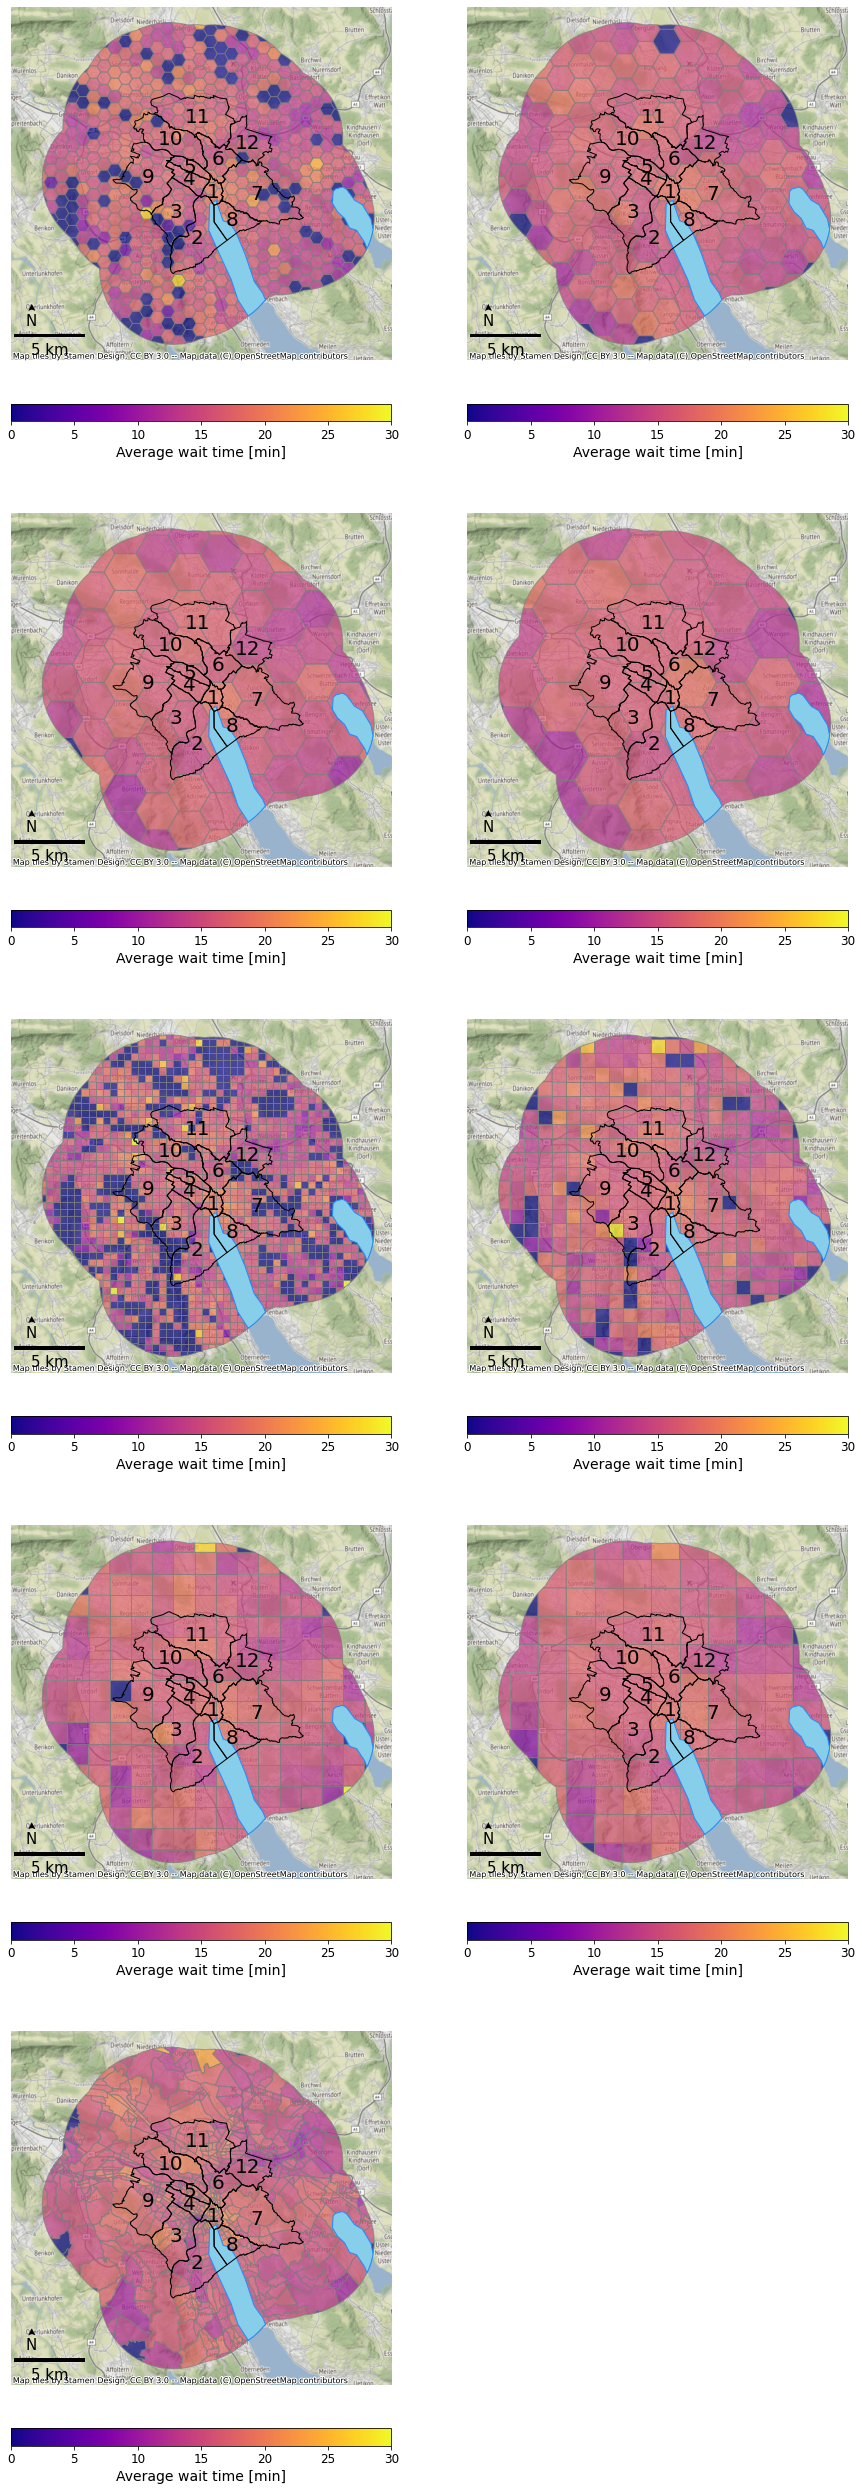

In [22]:
plot_multigrid_wait_time(outputs[200000], zurich_shp_path, lake_path, zurich_districts_path, vmax=30)

# First version without std

In [51]:
configs = ['global_average', 'zonal_hex', 'zonal_square', 'zonal_TAZ', 'dynamic_CN_k500_expDecay', 'dynamic_CN_k1000_expDecay', 'dynamic_CN_k2000_expDecay', 'dynamic_PN_km500_expDecay', 'dynamic_PN_km1000_expDecay', 'dynamic_PN_km2000_expDecay', 'dynamic_FD_expDecay']

In [52]:
fd_values = [100000, 200000, 300000, 400000, 500000]

In [53]:
outputs_v0 = {}
for fd_value in fd_values:
    outputs_v0[fd_value] = {}
    for c in tqdm(configs):
        path = os.path.join(work_folder,f'fixedDemand/v0/fixedDemand_{fd_value}/{c}')
        outputs_v0[fd_value][c] = read_fixed_demand_output(path)

100%|██████████| 11/11 [03:00<00:00, 16.39s/it]


In [54]:
def combine_simulated_predictions_and_stats(simulated_predictions, stats):
    simulated_predictions = simulated_predictions.copy(deep=True)
    stats = stats.copy(deep=True)
    
    simulated_predictions = simulated_predictions.add_suffix('_pred')
    simulated_predictions = simulated_predictions.rename(index=str, columns={'personId_pred':'personId', 'startTime_pred':'startTime'})

    stats = stats.add_suffix('_stats')
    stats = stats.rename(index=str, columns={'personId_stats':'personId', 'startTime_stats':'startTime'})
    
    return pd.merge(simulated_predictions, stats, on=['personId','startTime'], validate='one_to_one')

In [55]:
def compute_stats_table_v0(outputs_dict):
    description = pd.DataFrame()
    fd_values = list(outputs_dict.keys())
    configs = list(outputs_dict[fd_values[0]].keys())
    
    for fd_value in fd_values:
        for c in configs:
            o = outputs_dict[fd_value][c]
            simulated = o['drt_simulated_predictions']
            #merged = combine_simulated_predictions_and_stats(o['drt_simulated_predictions'], o['drt_trips_stats'])
            true_labels = simulated['real_waiTime'] / 60
            predicted_labels = simulated['predicted_waitTime'] / 60
            errors = true_labels - predicted_labels
            current_description = pd.Series(errors).describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])
            # Add mse, rmse, mae
            current_description['MSE'] = np.mean(errors**2)
            current_description['RMSE'] = np.sqrt(current_description['MSE'])
            current_description['MAE'] = np.mean(np.abs(errors))
            # Add percentage of errors below 0
            current_description['% errors < 0'] = np.sum(errors < 0)/len(errors) * 100
            current_description = pd.DataFrame(current_description).T
            full_title = str(fd_value) + '_' + c
            current_description['Demand'] = fd_value
            current_description['Method'] = c
            description = pd.concat([description, current_description], axis=0)
    description = description.set_index(['Demand', 'Method'])
    return description

In [56]:
compute_stats_table_v0(outputs_v0)

count          mean        std  \
Demand Method                                                          
100000 global_average               98183.0 -9.193062e-16  11.597574   
       zonal_hex                    98183.0 -4.216231e-16   7.720690   
       zonal_square                 98183.0 -3.193428e-16   7.422315   
       zonal_TAZ                    98183.0 -9.311822e-01   7.312045   
       dynamic_CN_k500_expDecay     98183.0  1.446051e-01   7.499504   
       dynamic_CN_k1000_expDecay    98183.0  1.392310e-01   7.522551   
       dynamic_CN_k2000_expDecay    98183.0  1.401290e-01   7.527326   
       dynamic_PN_km500_expDecay    98183.0  1.465162e-01   7.481747   
       dynamic_PN_km1000_expDecay   98183.0  1.464348e-01   7.481762   
       dynamic_PN_km2000_expDecay   98183.0  1.465858e-01   7.481730   
       dynamic_FD_expDecay          98183.0  1.448827e-01   7.409147   
200000 global_average              196199.0  2.442980e-14  11.497595   
       zonal_hex                   196199.0  1.115978e-16   8.154883   
       zonal_square                196199.0 -8.773183e-17   7.903116   
       zonal_TAZ                   196199.0 -8.755837e-01   7.969271   
       dynamic_CN_k500_expDecay    196199.0  1.250301e-01   7.917131   
       dynamic_CN_k1000_expDecay   196199.0  1.138880e-01   7.955395   
       dynamic_CN_k2000_expDecay   196199.0  1.092260e-01   7.974273   
       dynamic_PN_km500_expDecay   196199.0  1.251943e-01   7.915779   
       dynamic_PN_km1000_expDecay  196199.0  1.159342e-01   7.940460   
       dynamic_PN_km2000_expDecay  196199.0  1.159413e-01   7.940545   
       dynamic_FD_expDecay         196199.0  1.238741e-01   7.888105   
300000 global_average              294281.0 -4.164178e-15  11.127912   
       zonal_hex                   294281.0  3.058996e-16   8.151232   
       zonal_square                294281.0  7.078119e-17   7.936707   
       zonal_TAZ                   294281.0 -7.895296e-01   8.060097   
       dynamic_CN_k500_expDecay    294281.0  1.179052e-01   7.901126   
       dynamic_CN_k1000_expDecay   294281.0  9.234095e-02   7.948947   
       dynamic_CN_k2000_expDecay   294281.0  8.341368e-02   7.976586   
       dynamic_PN_km500_expDecay   294281.0  1.168208e-01   7.900350   
       dynamic_PN_km1000_expDecay  294281.0  9.305883e-02   7.945087   
       dynamic_PN_km2000_expDecay  294281.0  8.675390e-02   7.953329   
       dynamic_FD_expDecay         294281.0  9.799613e-02   7.904986   
400000 global_average              392280.0  4.604680e-14  11.549425   
       zonal_hex                   392280.0  1.840704e-16   8.753521   
       zonal_square                392280.0  3.127326e-16   8.541594   
       zonal_TAZ                   392280.0 -7.005799e-01   8.696400   
       dynamic_CN_k500_expDecay    392280.0  1.399147e-01   8.462415   
       dynamic_CN_k1000_expDecay   392280.0  8.336932e-02   8.541945   
       dynamic_CN_k2000_expDecay   392280.0  7.761811e-02   8.572637   
       dynamic_PN_km500_expDecay   392280.0  1.402471e-01   8.462437   
       dynamic_PN_km1000_expDecay  392280.0  8.418070e-02   8.540880   
       dynamic_PN_km2000_expDecay  392280.0  7.891192e-02   8.559481   
       dynamic_FD_expDecay         392280.0  9.350207e-02   8.517520   
500000 global_average              490533.0  2.621331e-14  11.688068   
       zonal_hex                   490533.0  4.793306e-17   9.003206   
       zonal_square                490533.0 -2.803594e-17   8.799152   
       zonal_TAZ                   490533.0 -6.121962e-01   8.978544   
       dynamic_CN_k500_expDecay    490533.0  1.600557e-01   8.644832   
       dynamic_CN_k1000_expDecay   490533.0  6.747549e-02   8.783832   
       dynamic_CN_k2000_expDecay   490533.0  6.121650e-02   8.814923   
       dynamic_PN_km500_expDecay   490533.0  1.574319e-01   8.644758   
       dynamic_PN_km1000_expDecay  490533.0  6.824691e-02   8.782929   
       dynamic_PN_km2000_expDecay  490533.0  6.297394e-02   8.807997   
      

In [57]:
def get_stats_table(output_dict):
    index_list = [("Number of rides", ""),
                    ("Wait time (min)", "Mean"),
                    ("Wait time (min)", "Median"),
                    ("Wait time (min)", "Std"),
                    ("Wait time (min)", "75-percentile"),
                    ("Wait time (min)", "99-percentile"),
                    ("Wait time (min)", "Max"),
                    ("Travel time (min)", "Mean"),
                    ("Travel time (min)", "Median"),
                    ("Travel time (min)", "Std"),
                    ("Travel time (min)", "75-percentile"),
                    ("Travel time (min)", "99-percentile"),
                    ("Travel time (min)", "Max"),
                    #("Mean distance (km)", ""),
                    ("Mean direct distance (km)", ""),
                    ("Average detour factor (time wise)", ""),
                    ("Total execution time", ""),
                  ]
    it_drt_trip_stats = output_dict['drt_trips_stats']
    index = pd.MultiIndex.from_tuples(index_list)
    stats = pd.DataFrame(index=index)
    stats.loc[("Number of rides", ""), "Value"] = len(it_drt_trip_stats)
    stats.loc[("Wait time (min)", "Mean"), "Value"] = it_drt_trip_stats.waitTime.mean() / 60
    stats.loc[("Wait time (min)", "Median"), "Value"] = it_drt_trip_stats.waitTime.median() / 60
    stats.loc[("Wait time (min)", "Std"), "Value"] = it_drt_trip_stats.waitTime.std() / 60
    stats.loc[("Wait time (min)", "75-percentile"), "Value"] = it_drt_trip_stats.waitTime.quantile(0.75) / 60
    stats.loc[("Wait time (min)", "99-percentile"), "Value"] = it_drt_trip_stats.waitTime.quantile(0.99) / 60
    stats.loc[("Wait time (min)", "Max"), "Value"] = it_drt_trip_stats.waitTime.max() / 60
    stats.loc[("Travel time (min)", "Mean"), "Value"] = it_drt_trip_stats.totalTravelTime.mean() / 60
    stats.loc[("Travel time (min)", "Median"), "Value"] = it_drt_trip_stats.totalTravelTime.median() / 60
    stats.loc[("Travel time (min)", "Std"), "Value"] = it_drt_trip_stats.totalTravelTime.std() / 60
    stats.loc[("Travel time (min)", "75-percentile"), "Value"] = it_drt_trip_stats.totalTravelTime.quantile(0.75) / 60
    stats.loc[("Travel time (min)", "99-percentile"), "Value"] = it_drt_trip_stats.totalTravelTime.quantile(0.99) / 60
    stats.loc[("Travel time (min)", "Max"), "Value"] = it_drt_trip_stats.totalTravelTime.max() / 60
    #stats.loc[("Mean distance (km)", ""), "Value"] = it_drt_trip_stats.distance.mean() / 1000
    stats.loc[("Mean direct distance (km)", ""), "Value"] = it_drt_trip_stats.euclideanDistance.mean() / 1000
    stats.loc[("Average detour factor (time wise)", ""), "Value"] = it_drt_trip_stats.delayFactor.mean()
    stats.loc[("Total execution time", ""), "Value"] = str(pd.to_timedelta(output_dict['stopwatch']['iteration']).sum())
    return stats

def get_multiple_stats_table(outputs):
    fd_values = list(outputs.keys())
    configs = list(outputs[fd_values[0]].keys())
    config_to_table = configs[0]
    tables = []
    for fd_value in fd_values:
        t = get_stats_table(outputs[fd_value][config_to_table])
        t.rename(columns={'Value': str(fd_value)}, inplace=True)
        tables.append(t)
    
    return pd.concat(tables, axis=1)

In [58]:
get_multiple_stats_table(outputs_v0)

100000  \
Number of rides                                            98183   
Wait time (min)                   Mean                   15.3112   
                                  Median                      13   
                                  Std                    11.5976   
                                  75-percentile          23.4333   
                                  99-percentile           44.053   
                                  Max                      139.8   
Travel time (min)                 Mean                   15.1508   
                                  Median                      12   
                                  Std                    11.9112   
                                  75-percentile             21.1   
                                  99-percentile          52.2167   
                                  Max                    205.067   
Mean direct distance (km)                                 5.8427   
Average detour factor (time wise)                        1.49103   
Total execution time                             0 days 00:50:43   

                                                          200000  \
Number of rides                                           196199   
Wait time (min)                   Mean                    14.388   
                                  Median                 11.8667   
                                  Std                    11.4976   
                                  75-percentile            21.75   
                                  99-percentile            43.85   
                                  Max                     242.35   
Travel time (min)                 Mean                   15.7669   
                                  Median                 12.5333   
                                  Std                    12.3245   
                                  75-percentile             22.3   
                                  99-percentile          53.4667   
                                  Max                    225.067   
Mean direct distance (km)                                5.86097   
Average detour factor (time wise)                         1.5335   
Total execution time                             0 days 01:31:50   

                                                          300000  \
Number of rides                                           294281   
Wait time (min)                   Mean                   13.6914   
                                  Median                 11.3333   
                                  Std                    11.1279   
                                  75-percentile             20.3   
                                  99-percentile          43.4333   
                                  Max                    198.267   
Travel time (min)                 Mean                   16.0646   
                                  Median                 12.8667   
                                  Std                    12.4732   
                                  75-percentile          22.8667   
                                  99-percentile          53.6333   
                                  Max                     212.95   
Mean direct distance (km)                                5.84562   
Average detour factor (time wise)                        1.56636   
Total execution time                             0 days 02:11:17   

                                                          400000  \
Number of rides                                           392280   
Wait time (min)                   Mean                   13.6004   
                                  Median                 11.1167   
                                  Std                    11.5494   
                                  75-percentile          19.9833   
                                  99-percentile          43.8667   
                                  Max                     298.55   
Travel time (min)                 Mean     

In [59]:
lake_path = "/cluster/work/ivt_vpl/mfrancesc/lake/g1s20.shp"
zurich_districts_path = "/cluster/work/ivt_vpl/mfrancesc/city_districts/data/stzh.adm_stadtkreise_v.shp"
zurich_shp_path = '/cluster/work/ivt_vpl/mfrancesc/ScenarioBoundary/zurich_city_5km.shp'

In [60]:
def plot_multigrid_wait_time(outputs_fd_value, zurich_shp_path, lake_path, zurich_districts_path, map_limit=None, vmax=None):
    zurich_shp = gpd.read_file(zurich_shp_path)

    plt.figure(figsize=(15,18))
    zone_types = ['zonal_hex', 'zonal_square', 'zonal_TAZ']
    for idx,zt in enumerate(zone_types,start=0):
        plt.subplot(2,2,idx+1)
        zones = outputs_fd_value[zt]['fixedZones'].set_crs('EPSG:2056', allow_override=True)
        if map_limit is None:
            map_limit = zurich_shp.loc[0].geometry
        lake_limit = map_limit
        zones = gpd.clip(zones, map_limit)

        
        zone_id_field = "ID" if zt == 'zonal_TAZ' else 'zoneId'
            
        it_drt_trips_stats_gpd = utils.convert_drt_legs_to_gpd(outputs_fd_value[zt]['drt_trips_stats'])
        imputed = plotting_utils.impute(it_drt_trips_stats_gpd, zones, "trip_id", zone_id_field,fix_by_distance=False).drop("geometry", axis=1)
        metrics = plotting_utils.get_metrics_for_zonal_plot(imputed, zones, zone_id_field, metrics=["waitTime"])
        plotting_utils.plot_zonal_avg(metrics, zones, 'waitTime', lake_limit, lake_path,
                            zurich_districts_path,"Average wait time [min]",
                              add_map=True, in_subplot=True, vmax=vmax)
        #plt.title('grid size = ' + str(gs) + 'm', fontsize=14)
        '''
        plt.subplot(3,2,idx*2+2)
        grouped_by_n_trips = imputed.groupby(zone_id_field) \
                                .agg(columnAvg=('waitTime', 'mean'), nTrips=('trip_id','size'))
        
        x = grouped_by_n_trips.nTrips
        y = grouped_by_n_trips.columnAvg / 60
        sns.regplot(x=x,y=y)
        plt.ylim(0, vmax)
        plt.ylabel('Waiting time (min)', fontsize=12)
        plt.xlabel('Number of trips', fontsize=12)
        #plt.title('grid size = ' + str(gs) + 'm', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        '''
        
    #plt.tight_layout()
    plt.show()

Imputing 50  zones onto 98183  points by spatial join...


100%|██████████| 9/9 [00:01<00:00,  7.09it/s]


Imputing 120  zones onto 98183  points by spatial join...


100%|██████████| 9/9 [00:01<00:00,  6.75it/s]


Imputing 684  zones onto 98183  points by spatial join...


100%|██████████| 9/9 [00:01<00:00,  5.97it/s]


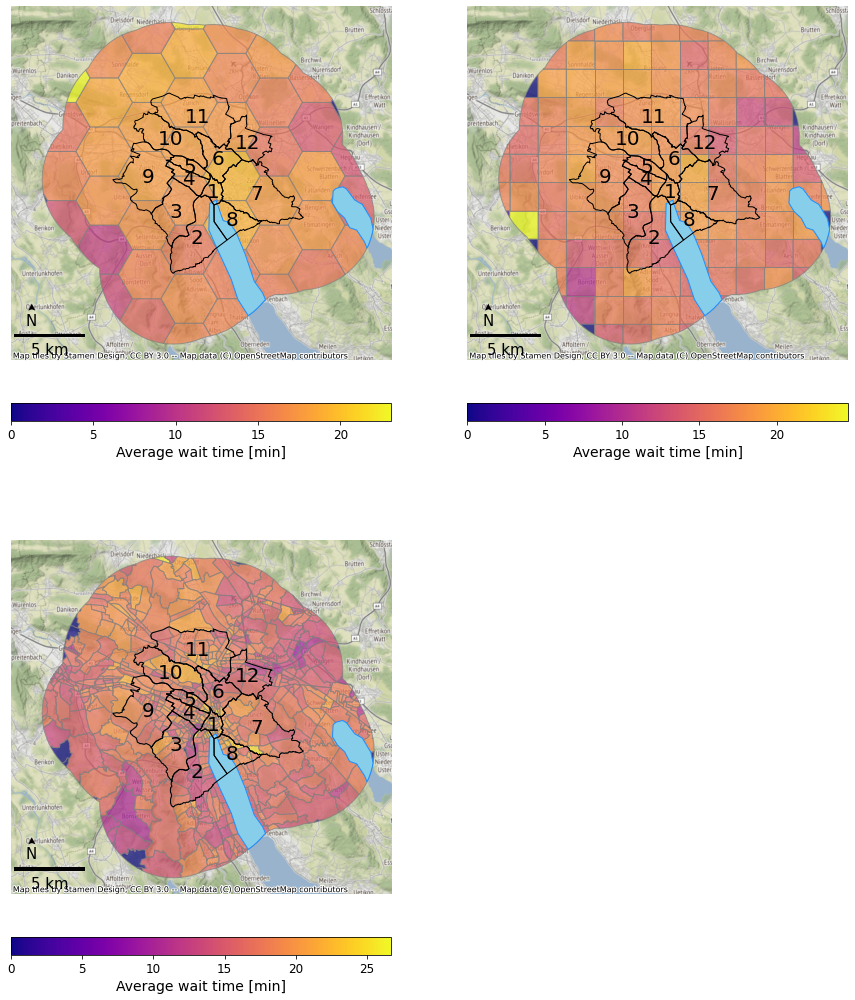

In [61]:
plot_multigrid_wait_time(outputs_v0[100000], zurich_shp_path, lake_path, zurich_districts_path)

Imputing 50  zones onto 196199  points by spatial join...


100%|██████████| 19/19 [00:02<00:00,  7.02it/s]


Imputing 120  zones onto 196199  points by spatial join...


100%|██████████| 19/19 [00:02<00:00,  7.06it/s]


Imputing 684  zones onto 196199  points by spatial join...


100%|██████████| 19/19 [00:02<00:00,  6.63it/s]


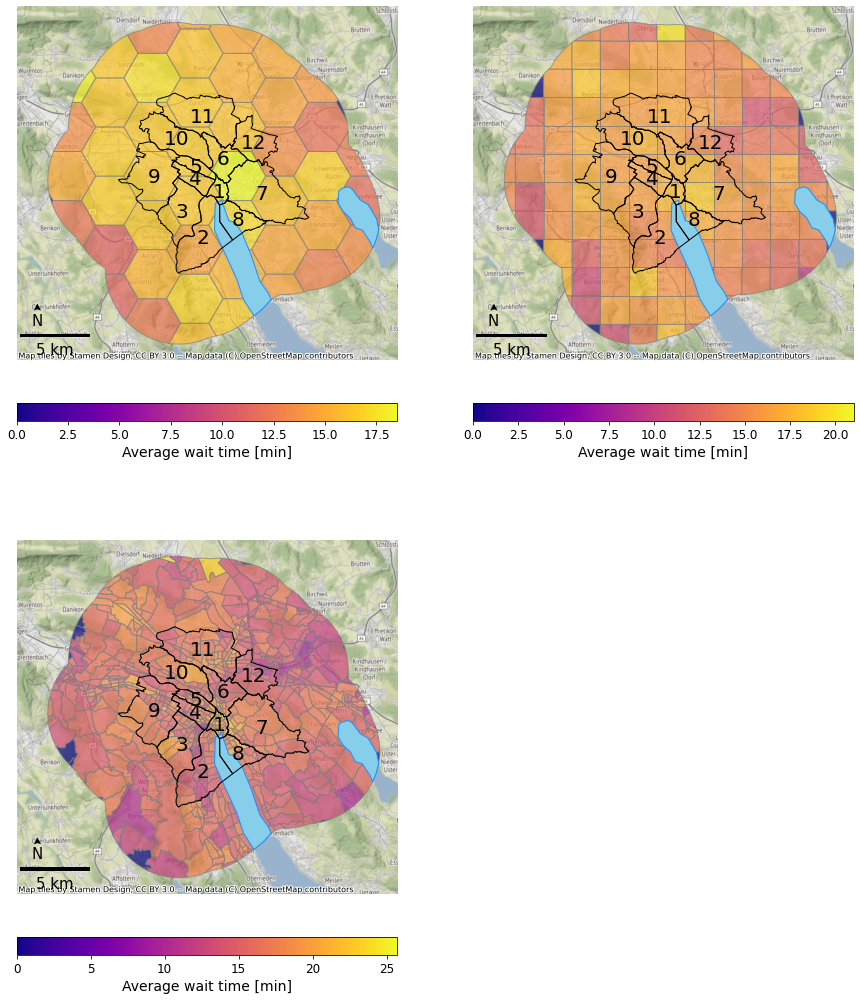

In [62]:
plot_multigrid_wait_time(outputs_v0[200000], zurich_shp_path, lake_path, zurich_districts_path)

Imputing 50  zones onto 294281  points by spatial join...


100%|██████████| 29/29 [00:04<00:00,  7.12it/s]


Imputing 120  zones onto 294281  points by spatial join...


100%|██████████| 29/29 [00:04<00:00,  7.17it/s]


Imputing 684  zones onto 294281  points by spatial join...


100%|██████████| 29/29 [00:04<00:00,  6.60it/s]


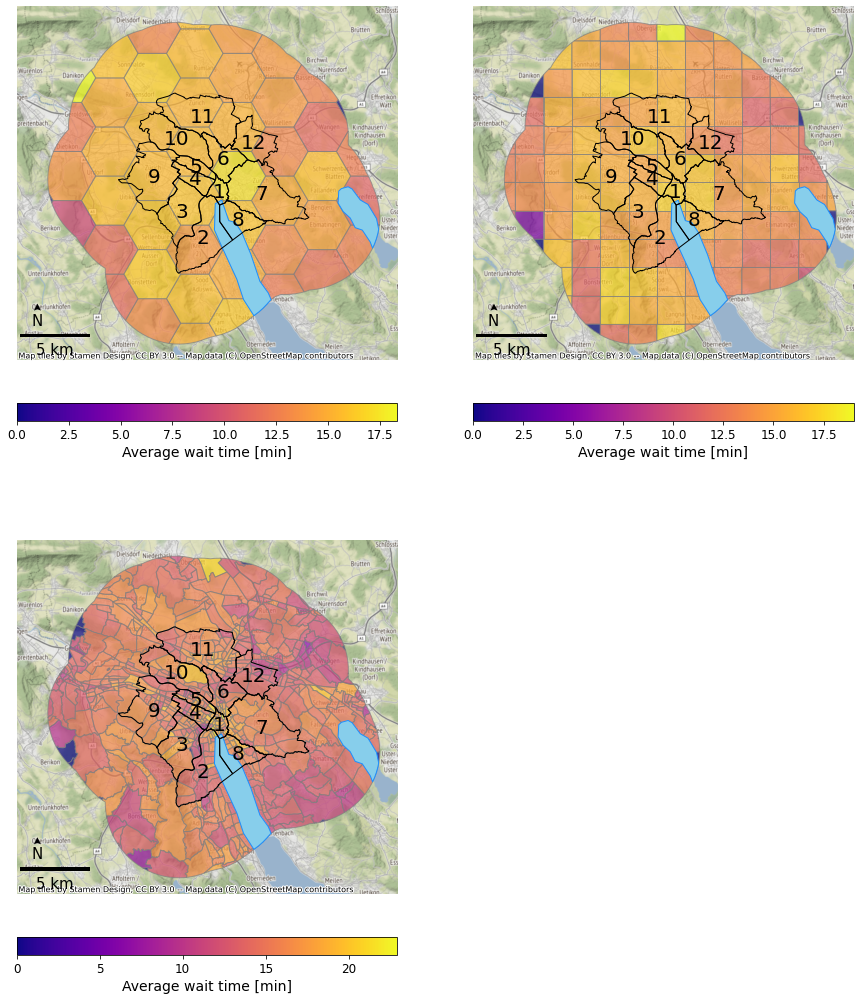

In [63]:
plot_multigrid_wait_time(outputs_v0[300000], zurich_shp_path, lake_path, zurich_districts_path)

Imputing 50  zones onto 392280  points by spatial join...


100%|██████████| 39/39 [00:05<00:00,  7.13it/s]


Imputing 120  zones onto 392280  points by spatial join...


100%|██████████| 39/39 [00:05<00:00,  7.19it/s]


Imputing 684  zones onto 392280  points by spatial join...


100%|██████████| 39/39 [00:05<00:00,  6.55it/s]


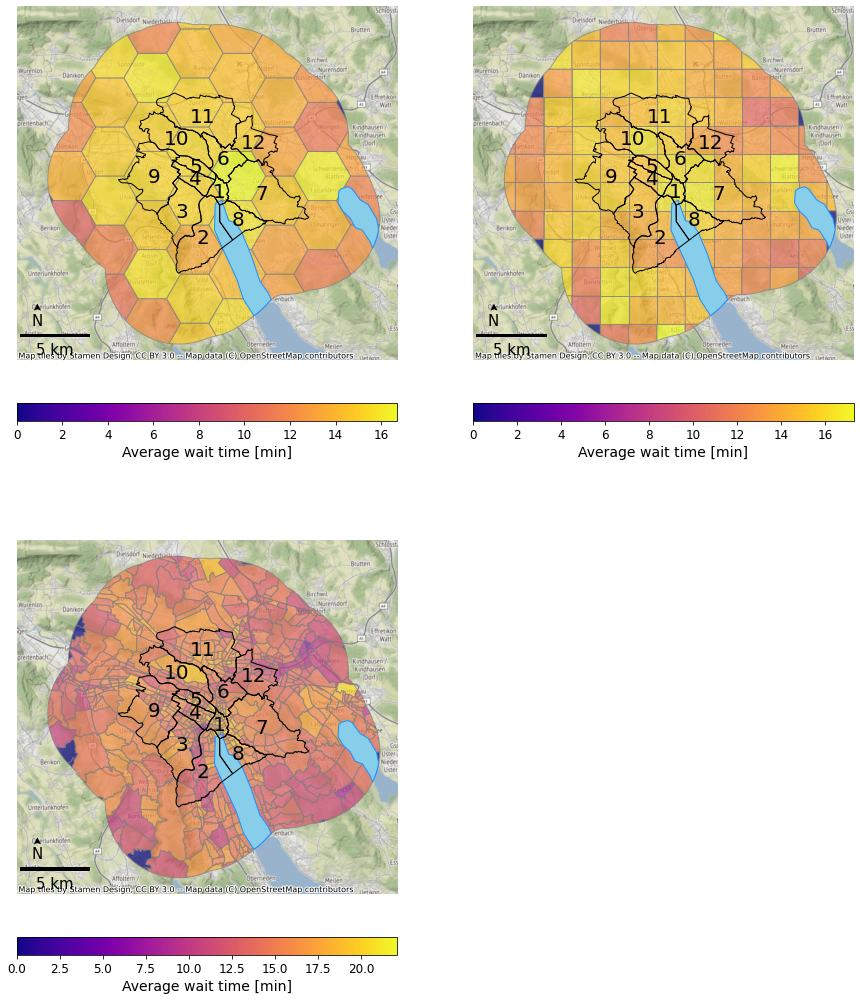

In [64]:
plot_multigrid_wait_time(outputs_v0[400000], zurich_shp_path, lake_path, zurich_districts_path)

Imputing 50  zones onto 490533  points by spatial join...


100%|██████████| 49/49 [00:06<00:00,  7.29it/s]


Imputing 120  zones onto 490533  points by spatial join...


100%|██████████| 49/49 [00:06<00:00,  7.10it/s]


Imputing 684  zones onto 490533  points by spatial join...


100%|██████████| 49/49 [00:07<00:00,  6.64it/s]


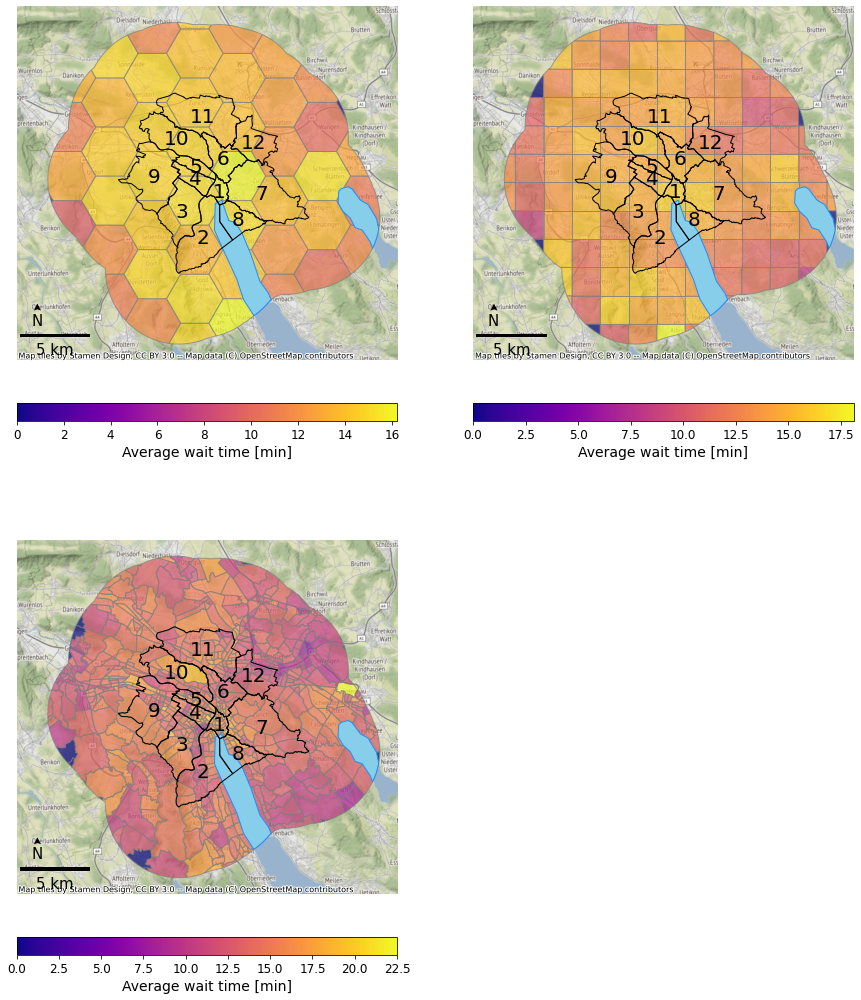

In [65]:
plot_multigrid_wait_time(outputs_v0[500000], zurich_shp_path, lake_path, zurich_districts_path)